# 🧪 Fertilizer Dosage Prediction Pipeline (Tunisia)

This notebook presents a complete machine learning workflow to **predict optimal fertilizer dosage** using real-world agricultural data from Tunisia.

### 📌 Key Components:
- **Exploratory Data Analysis (EDA)**: Understand data distributions and correlations
- **Data Preprocessing**: Handle missing values, outliers, skewness, and encoding
- **Feature Engineering**: Create interaction features and nutrient deficit metrics
- **Modeling & Tuning**: Random Forest, XGBoost, and Ridge Regression with `RandomizedSearchCV`
- **Evaluation**: MAE, RMSE, R², and insights into important predictors

> 🚜 BO:
Provide accurate fertilizer dosage recommendations to improve crop yield and reduce waste in Tunisia.

>DSO:
Build a regression model to predict optimal fertilizer dosage based on soil, crop, and fertilizer data.



# **Data understanding**

In [3]:
from google.colab import files
import pandas as pd

# Upload file manually
uploaded = files.upload()

Saving dosage_crop.csv to dosage_crop.csv


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import missingno as msno

In [29]:
data = pd.read_csv('dosage_crop.csv', delimiter=';', encoding='utf-8')
print(data.shape)

# Display sample data and info
display(data.head())
data.info()
print(data.describe())


(10000, 20)


,Fertilizer Name,N (%),P (%),K (%),Fertilizer Type,Absorption Rate (%),Price per kg (TND),State,Region of Use in Tunisia,Specific Crop,Crop N,Crop P,Crop K,Application Method,Root Depth (cm),Soil_P,Soil_K,Soil_N,pH,Usage (Dosage)
0,BIOFERT ORGANIC,15,15,10,Organic,75,2.99,Sidi Bouzid,Central,Corn,142,61,34,Radicular,70,11.600000,77.300000,21.300000,7.286931,7.88
1,FLOCROP B,15,10,5,Liquid,70,2.34,Bizerte,North,Olive,146,70,40,Radicular and Foliar,80,28.446521,83.065767,46.385579,7.114031,13.93
2,FERTIMAX 15-15-15,15,15,15,Granular,60,3.23,Sousse,Central,Corn,142,61,34,Soil Application,70,NaN,61.697723,49.100000,7.686568,5.00
3,MOLYBDENUM PLUS,5,10,5,Chemical,79,2.06,Tataouine,South,Tomato,142,33,22,Foliar,45,22.931627,81.817345,23.831130,7.663094,15.23
4,MAP 11-52-0,11,52,0,Liquid,90,3.88,Monastir,Central,Potato,61,62,21,Soil Application,50,12.500000,92.300000,20.821715,7.825692,46.38


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fertilizer Name           10000 non-null  object 
 1   N (%)                     10000 non-null  int64  
 2   P (%)                     10000 non-null  int64  
 3   K (%)                     10000 non-null  int64  
 4   Fertilizer Type           10000 non-null  object 
 5   Absorption Rate (%)       10000 non-null  int64  
 6   Price per kg (TND)        10000 non-null  float64
 7   State                     10000 non-null  object 
 8   Region of Use in Tunisia  10000 non-null  object 
 9   Specific Crop             10000 non-null  object 
 10  Crop N                    10000 non-null  int64  
 11  Crop P                    10000 non-null  int64  
 12  Crop K                    10000 non-null  int64  
 13  Application Method        10000 non-null  object 
 14  Root De

In [30]:
data.shape

(10000, 20)

In [31]:
# List of categorical columns to analyze
un_cols = [
    'Fertilizer Name',
    'Fertilizer Type',
    'State',
    'Region of Use in Tunisia',
    'Specific Crop',
    'Application Method'
]

# Display unique values for each column
for col in un_cols:
    unique_vals = data[col].unique()
    print(f"\n🔹 {col} ({len(unique_vals)} unique values):")
    print(np.sort(unique_vals))  # Sorted output for better readability


🔹 Fertilizer Name (154 unique values):
['ACA 27 ORGANIC' 'ACM AMINO 12 VEGETAL' 'ACM AMINO 45 SOLID' 'ACM BORO'
 'ACM CALCIO PLUS' 'ACM CITRUS' 'ACM COBRE' 'ACM FUL EXTRA' 'ACM HIERRO'
 'ACM HUMIC' 'ACM MAR 20' 'ACM MAR S' 'ACM POTASIO GEL' 'ACM SEAFORCE'
 'AGRI M40' 'AGRIFUL' 'AGRIPHYT CONTACT Zn-Mn' 'AGROGOLD 20-20-20'
 'ALGA-PLEX' 'ALGADUL' 'ALGALIV' 'ALGAMAX ORGANIC' 'ALGAPOWER'
 'AMINO Mn/Zn' 'AMINOPLUS ORGANIC' 'AMMONIUM SULFATE' 'ASCOFILLUM'
 'Ammonium Nitrate' 'BASFOLIAR SIZE SL' 'BESTCURE' 'BIFIDUS' 'BIOCAL'
 'BIOCALCIUM' 'BIOFERT ORGANIC' 'BIORADICANTE' 'BIOZINC' 'BLACKFORT'
 'BLACKJAK' 'BOMBARDIER' 'BOMBARDIER SUGAR' 'BORKO' 'BORON PLUS'
 'BOTAMISOL PRO 80' 'CALCIUM NITRATE' 'CALFERT 15-0-0 + 20CaO'
 'CALMAG 10-0-0 + 12CaO + 6MgO' 'CAOS XT' 'CONTROLPHYT Cu'
 'COPPER SULFATE' 'CRIPTHUM' 'CUPRO ACTIV' 'DAP' 'DAP 18-46-0'
 'DCM VIVIKALI' 'DEFENDER CALCIO' 'DEFENDER MZ' 'ECKLOMAR' 'ECOFERT 5-3-4'
 'ECORMON' 'ESPARTAN' 'FARINA DI BASALTO' 'FERROACTIV H48'
 'FERTICROP ORGANIC PLU

In [32]:
# Check for missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Soil_P    212
Soil_K    207
Soil_N    202
dtype: int64


## **Data Understanding & EDA**

In [33]:
'''# Supprimer les lignes où le dosage est supérieur à 400
data = data[data["Usage (Dosage)"] <= 400]

# Sauvegarder le nouveau fichier
data.to_csv("augmented_filtered.csv", sep=';', index=False)
'''

'# Supprimer les lignes où le dosage est supérieur à 400\ndata = data[data["Usage (Dosage)"] <= 400]\n\n# Sauvegarder le nouveau fichier\ndata.to_csv("augmented_filtered.csv", sep=\';\', index=False)\n'

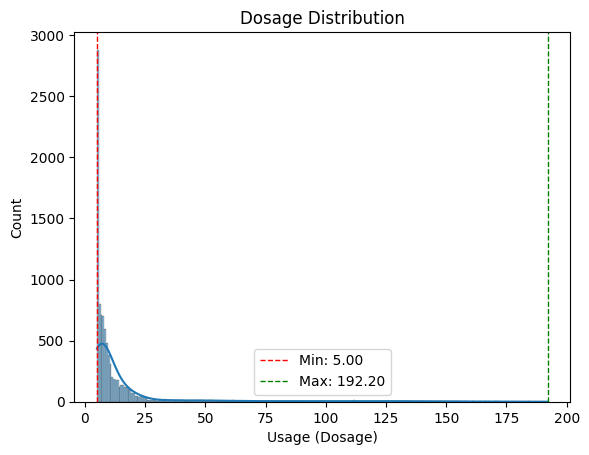

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram with KDE
sns.histplot(data['Usage (Dosage)'], kde=True)
plt.title('Dosage Distribution')

# Calculate min and max
min_val = data['Usage (Dosage)'].min()
max_val = data['Usage (Dosage)'].max()

# Add vertical lines for min and max
plt.axvline(min_val, color='red', linestyle='--', linewidth=1, label=f'Min: {min_val:.2f}')
plt.axvline(max_val, color='green', linestyle='--', linewidth=1, label=f'Max: {max_val:.2f}')

# Add legend to show the values
plt.legend()

# Alternatively, you can use text annotations
# plt.text(min_val, plt.ylim()[1]*0.9, f'Min: {min_val:.2f}', color='red')
# plt.text(max_val, plt.ylim()[1]*0.8, f'Max: {max_val:.2f}', color='green')

plt.show()

The dosage distribution plot reveals a wide range of values, spanning from a minimum of 5.00 to a maximum of 192.20. This substantial spread (a 38-fold difference between the lowest and highest values) suggests several potential scenarios and analytical considerations

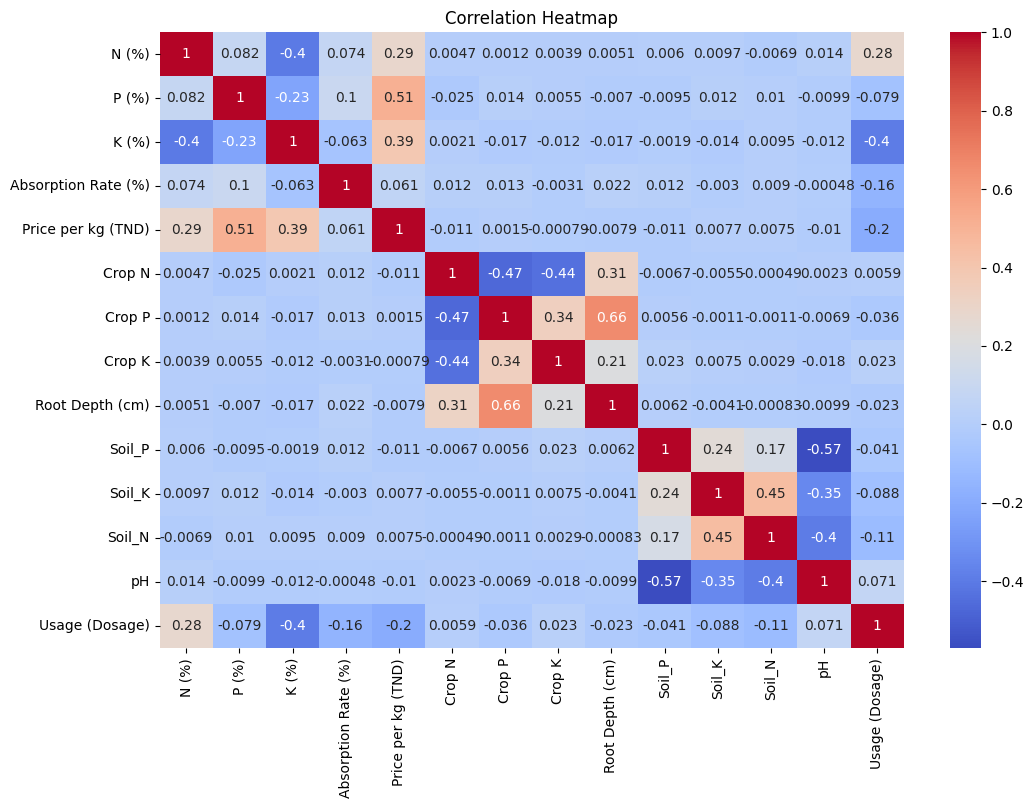

In [35]:
# Correlation heatmap
numeric_cols = data.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



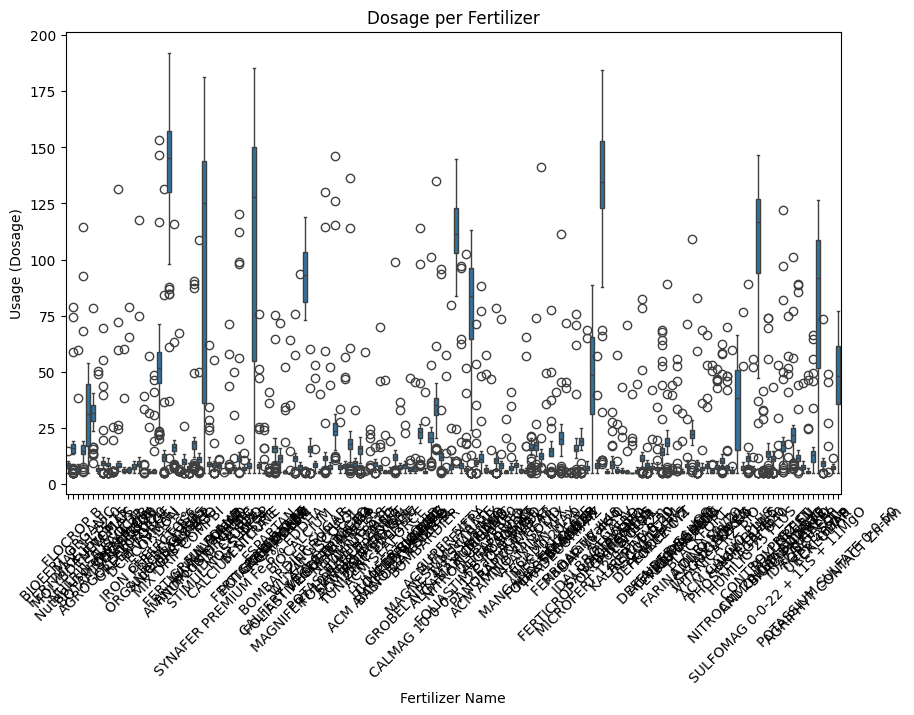

In [36]:
# Boxplot of dosage by fertilizer
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Fertilizer Name', y='Usage (Dosage)')
plt.xticks(rotation=45)
plt.title("Dosage per Fertilizer")
plt.show()

Text(0.5, 1.0, 'Nitrogen (N) Distribution')

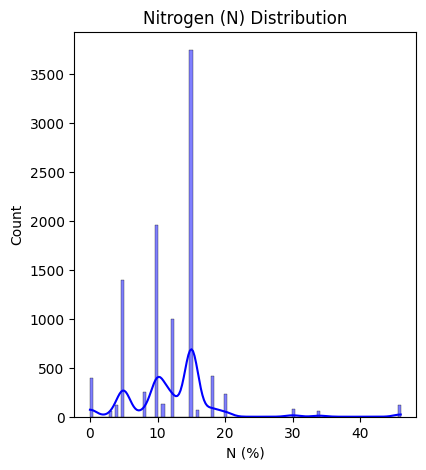

In [37]:
# =============================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================

# Nutrient composition analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['N (%)'], kde=True, color='blue')
plt.title('Nitrogen (N) Distribution')



Text(0.5, 1.0, 'Phosphorus (P) Distribution')

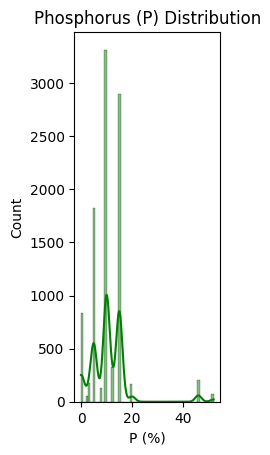

In [38]:
plt.subplot(1, 3, 2)
sns.histplot(data['P (%)'], kde=True, color='green')
plt.title('Phosphorus (P) Distribution')



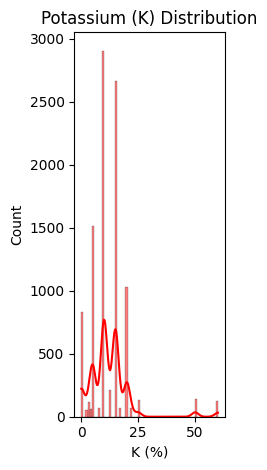

In [39]:
plt.subplot(1, 3, 3)
sns.histplot(data['K (%)'], kde=True, color='red')
plt.title('Potassium (K) Distribution')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ph')

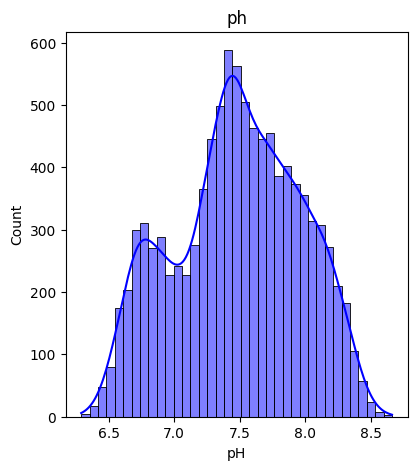

In [40]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['pH'], kde=True, color='blue')
plt.title('ph')



<ipython-input-41-6b8539a69c21>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fertilizer Type', data=data, palette='viridis')


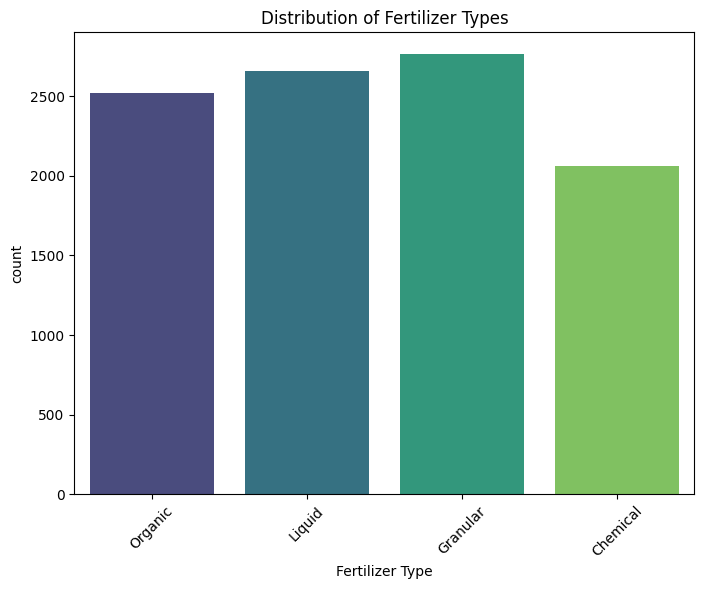

In [41]:
# Fertilizer type distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Fertilizer Type', data=data, palette='viridis')
plt.title('Distribution of Fertilizer Types')
plt.xticks(rotation=45)
plt.show()

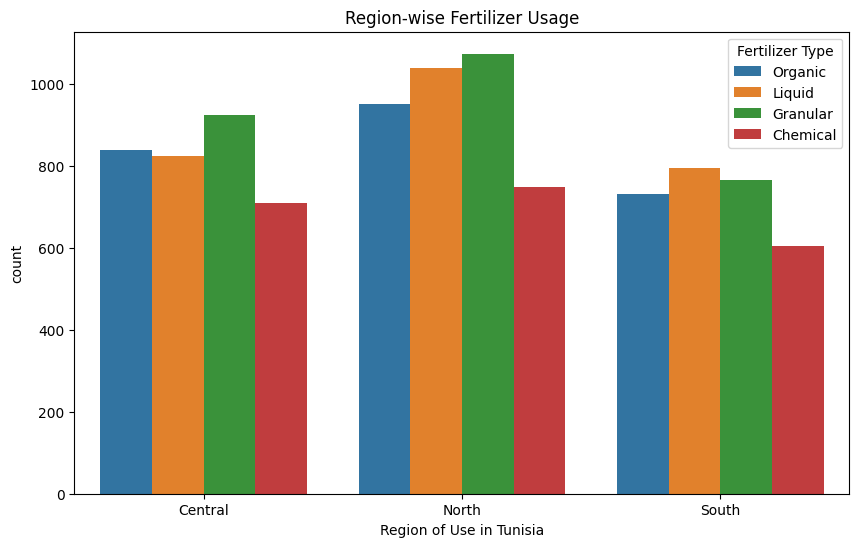

In [42]:
# 3. Region-wise Fertilizer Usage
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Region of Use in Tunisia', hue='Fertilizer Type')
plt.title("Region-wise Fertilizer Usage")
plt.show()


North: Prefers Liquid & Organic fertilizers.
South: Highest Liquid fertilizer use (~100 count).
Central: More Chemical fertilizers used than other regions.
🔹 Modeling Insight: Region is a key factor in fertilizer recommendation. Consider interaction effects between Region & Fertilizer Type.

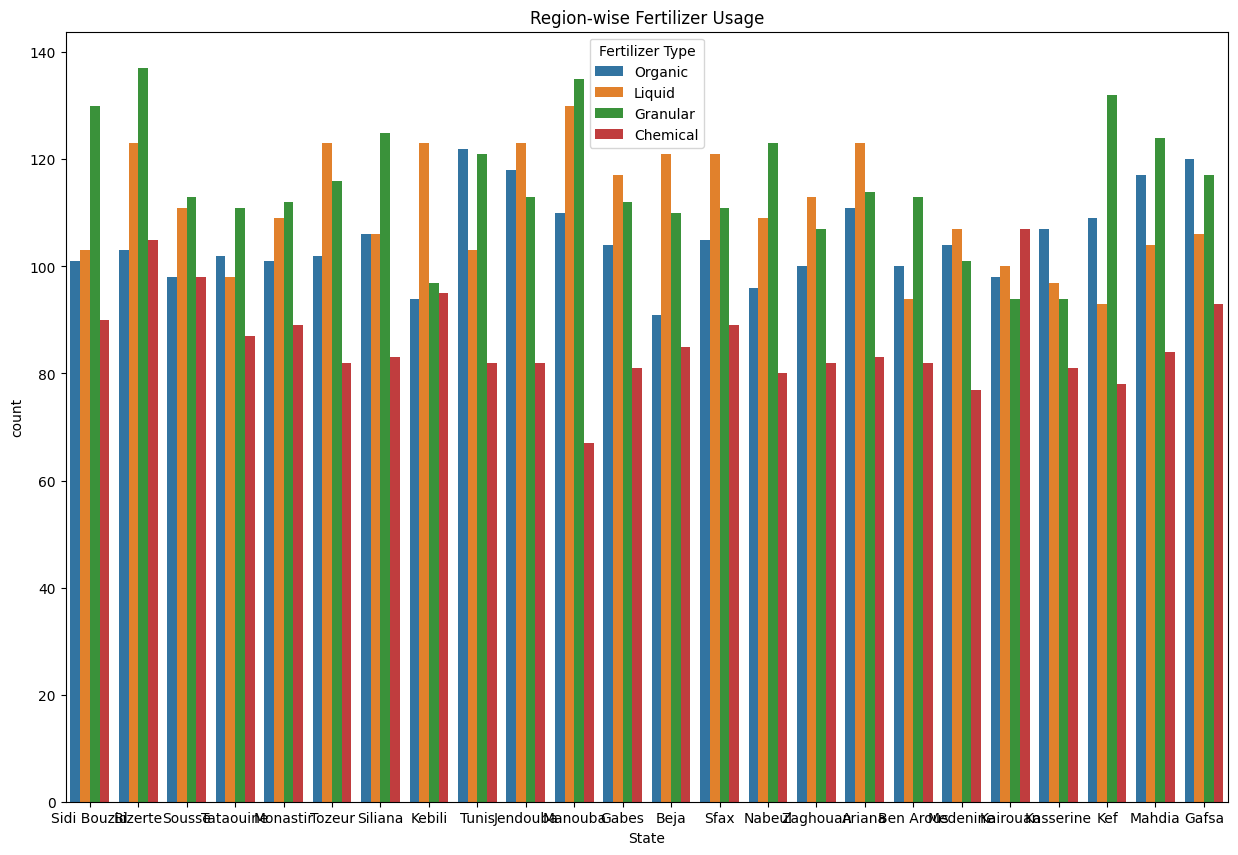

In [43]:
# State wise Fertilizer Usage
plt.figure(figsize=(15, 10))
sns.countplot(data=data, x='State', hue='Fertilizer Type')
plt.title("Region-wise Fertilizer Usage")
plt.show()


# **Data Preparation**

Skewness of Dosage: 3.618403581672022


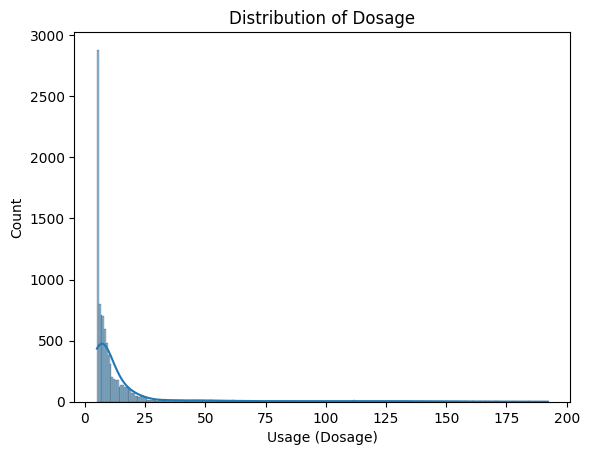

In [44]:
print("Skewness of Dosage:", data['Usage (Dosage)'].skew())
sns.histplot(data['Usage (Dosage)'], kde=True)
plt.title("Distribution of Dosage")
plt.show()

In [45]:
# -----------------------------------
# 1. CONVERT NUMERIC STRINGS TO FLOAT
# -----------------------------------
numeric_columns = [
    'N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
    'Soil_N', 'Soil_P', 'Soil_K', 'Crop N', 'Crop P', 'Crop K',
    'Root Depth (cm)', 'pH', 'Usage (Dosage)'
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [46]:
# Soil-specific imputation (median per region)
for nutrient in ['Soil_N', 'Soil_P', 'Soil_K']:
    data[nutrient] = data.groupby('Region of Use in Tunisia')[nutrient].transform(
        lambda x: x.fillna(x.median())
    )

# Fallback to overall median if regional data is unavailable
soil_cols = ['Soil_N', 'Soil_P', 'Soil_K']
data[soil_cols] = data[soil_cols].fillna(data[soil_cols].median())

In [47]:
'''original_size = len(data)
data = data.dropna(subset=['Usage (Dosage)'])
print(f"Removed {original_size - len(data)} rows with missing dosage")'''

'original_size = len(data)\ndata = data.dropna(subset=[\'Usage (Dosage)\'])\nprint(f"Removed {original_size - len(data)} rows with missing dosage")'

In [48]:
# Check for missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Series([], dtype: int64)


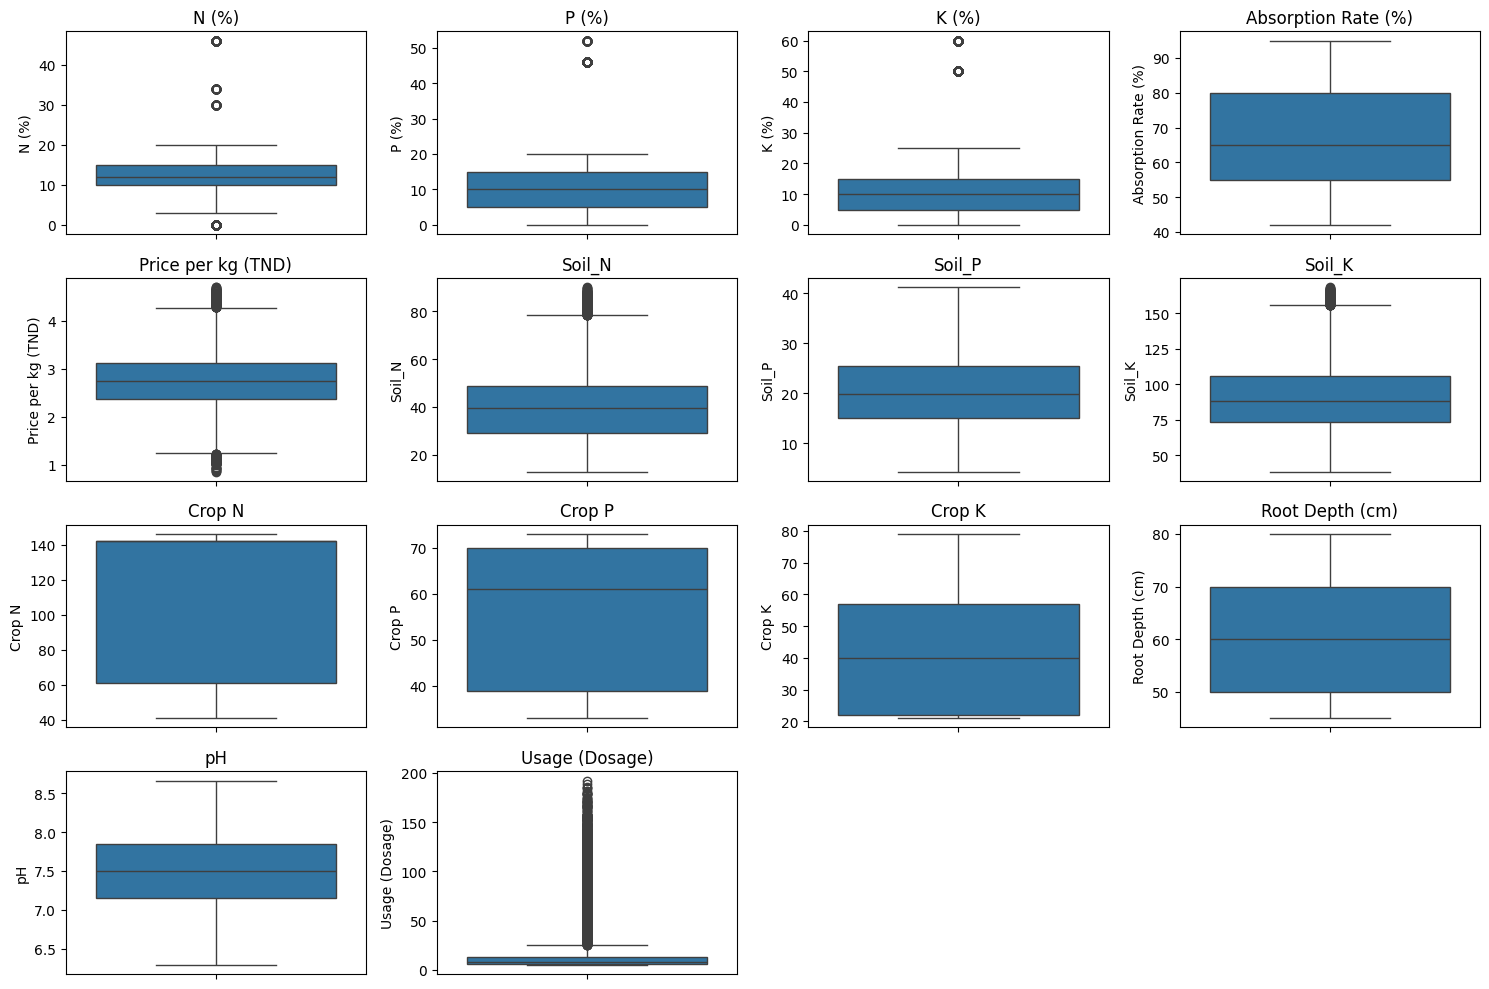

In [49]:
# 5. Check for Outliers
# Visualize outliers using boxplots for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [50]:
# 1. Cap features (exclude target)
features_to_cap = [col for col in numeric_columns if col != 'Usage (Dosage)']
for col in features_to_cap:
    q_low, q_high = data[col].quantile([0.05, 0.95])
    data[col] = np.clip(data[col], q_low, q_high)

# Recalculate skew without 'Usage (Dosage)'
numeric_features = [col for col in numeric_columns if col != 'Usage (Dosage)']
skewed = data[numeric_features].skew()
to_log = skewed[abs(skewed) > 1.5].index

# Apply log1p only to highly skewed features (excluding target)
data[to_log] = data[to_log].apply(np.log1p)


Skewness of Dosage: 3.618403581672022


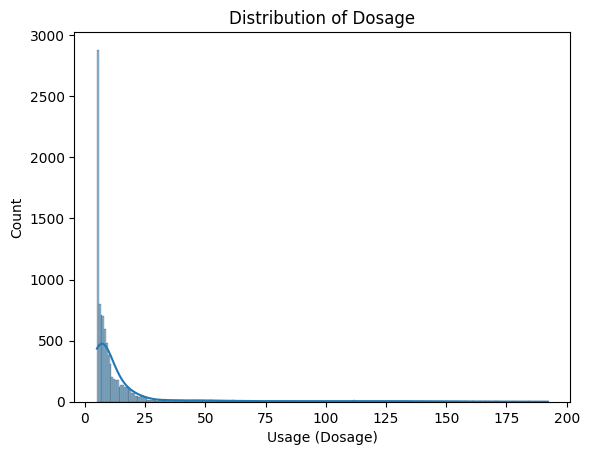

In [51]:
print("Skewness of Dosage:", data['Usage (Dosage)'].skew())
sns.histplot(data['Usage (Dosage)'], kde=True)
plt.title("Distribution of Dosage")
plt.show()

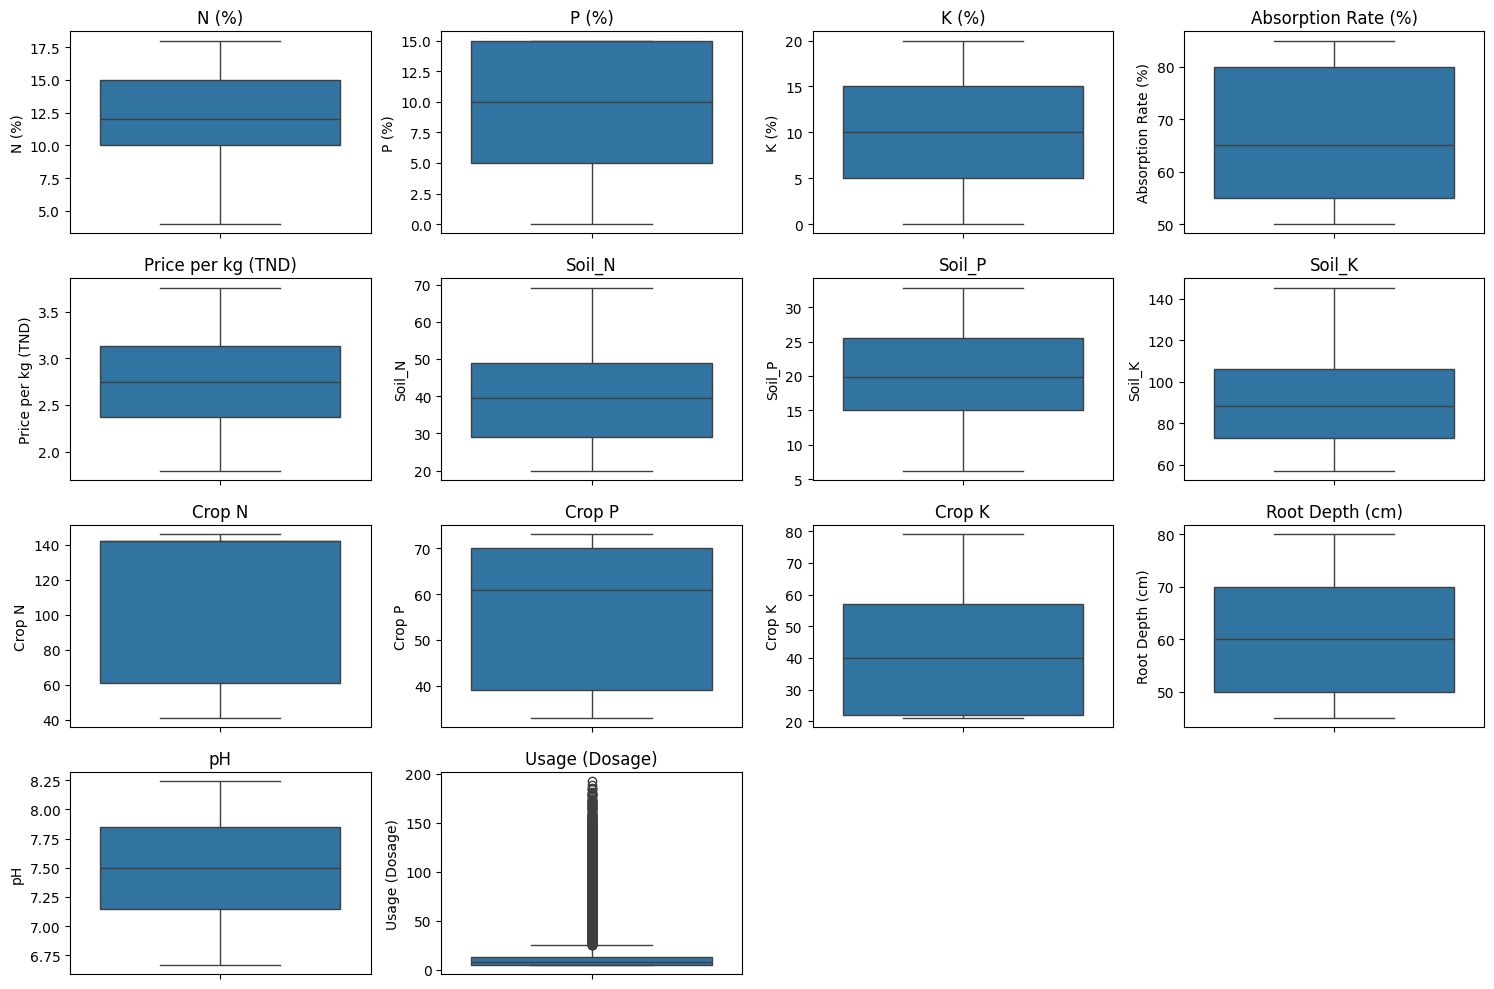

In [52]:
# Visualisation des outliers (après capping + log)
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

pH Value Counts:
pH
6.667173    500
6.667185      1
6.667220      1
6.667989      1
6.668200      1
           ... 
8.238768      1
8.238952      1
8.239131      1
8.239261      1
8.239270    500
Name: count, Length: 9002, dtype: int64

pH Distribution Stats:
count    10000.000000
mean         7.481490
std          0.462659
min          6.667173
25%          7.150646
50%          7.495166
75%          7.846404
max          8.239270
Name: pH, dtype: float64


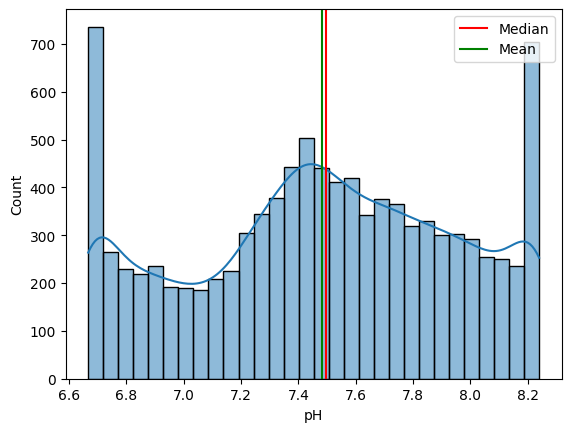

In [53]:
print("pH Value Counts:")
print(data['pH'].value_counts().sort_index())

print("\npH Distribution Stats:")
print(data['pH'].describe())

sns.histplot(data['pH'], bins=30, kde=True)
plt.axvline(x=data['pH'].median(), color='red', label='Median')
plt.axvline(x=data['pH'].mean(), color='green', label='Mean')
plt.legend()

In [54]:
data["NPK_ratio"] = data["N (%)"] / (data["P (%)"] + data["K (%)"] + 1e-3)

data["N_gap"] = data["Crop N"] - data["N (%)"]
data["P_gap"] = data["Crop P"] - data["P (%)"]
data["K_gap"] = data["Crop K"] - data["K (%)"]

data["Soil_P_suff"] = data["Soil_P"] / (data["Crop P"] + 1e-3)
data["Soil_K_suff"] = data["Soil_K"] / (data["Crop K"] + 1e-3)
data["Soil_N_suff"] = data["Soil_N"] / (data["Crop N"] + 1e-3)

data["N_gap"] = data["Crop N"] - data["N (%)"]
data["P_gap"] = data["Crop P"] - data["P (%)"]
data["K_gap"] = data["Crop K"] - data["K (%)"]

data["Effective_N"] = data["N (%)"] * data["Absorption Rate (%)"] / 100
data["Effective_P"] = data["P (%)"] * data["Absorption Rate (%)"] / 100
data["Effective_K"] = data["K (%)"] * data["Absorption Rate (%)"] / 100




| Feature         | Meaning                                                                |
|----------------|------------------------------------------------------------------------|
| `NPK_ratio`     | Fertilizer formulation skew — how N-heavy it is.                       |
| `*_gap`         | Nutrient need vs fertilizer content.                                   |
| `Soil_*_suff`   | How much the soil alone contributes toward fulfilling crop needs.      |
| `Effective_*`   | Adjusted fertilizer nutrient availability, considering absorption rate. |


Top correlated features with Usage (Dosage):
Usage (Dosage)         1.000000
NPK_ratio              0.662345
K_gap                  0.174096
N (%)                  0.079895
pH                     0.070551
P_gap                  0.057044
Crop K                 0.023058
Effective_N            0.014854
Crop N                 0.005879
N_gap                 -0.002226
Soil_P_suff           -0.011022
Root Depth (cm)       -0.023340
Crop P                -0.035893
Soil_K_suff           -0.040622
Soil_P                -0.041439
Soil_K                -0.078500
Soil_N_suff           -0.094766
Soil_N                -0.113080
Absorption Rate (%)   -0.149842
Price per kg (TND)    -0.192225
P (%)                 -0.303378
Effective_P           -0.320578
Effective_K           -0.537118
K (%)                 -0.551847
Name: Usage (Dosage), dtype: float64


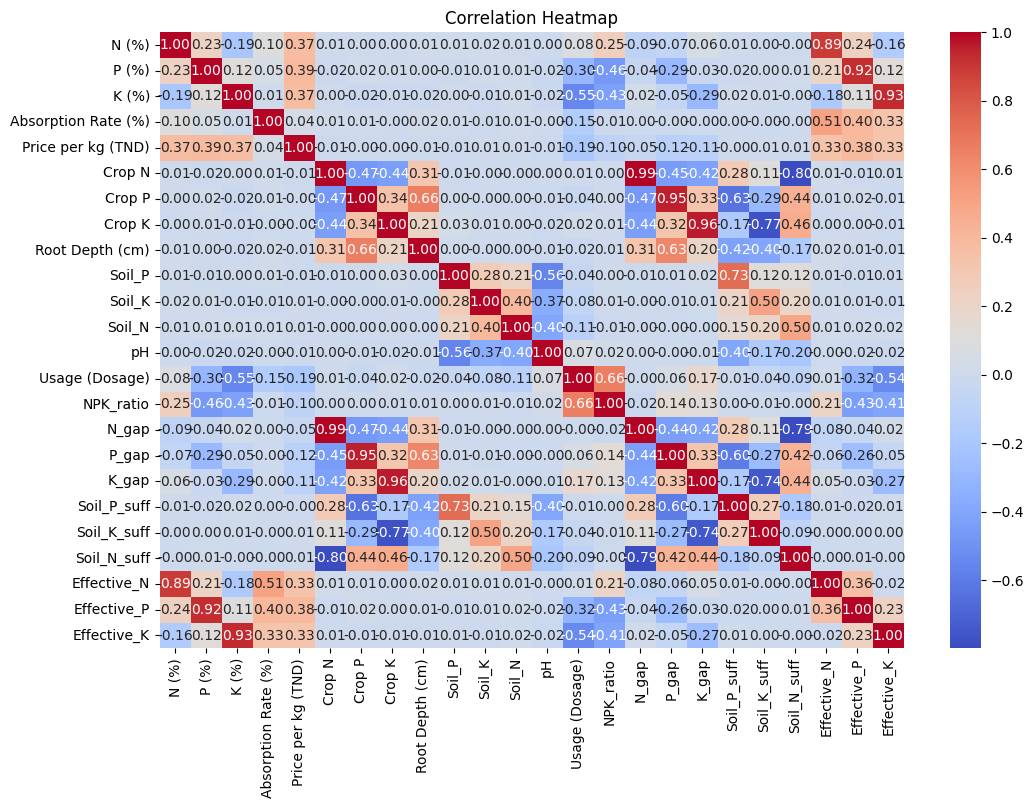

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features
numerical_features = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation with the target
correlation_with_target = numerical_features.corr()['Usage (Dosage)'].sort_values(ascending=False)

# Display top correlations
print("Top correlated features with Usage (Dosage):")
print(correlation_with_target)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


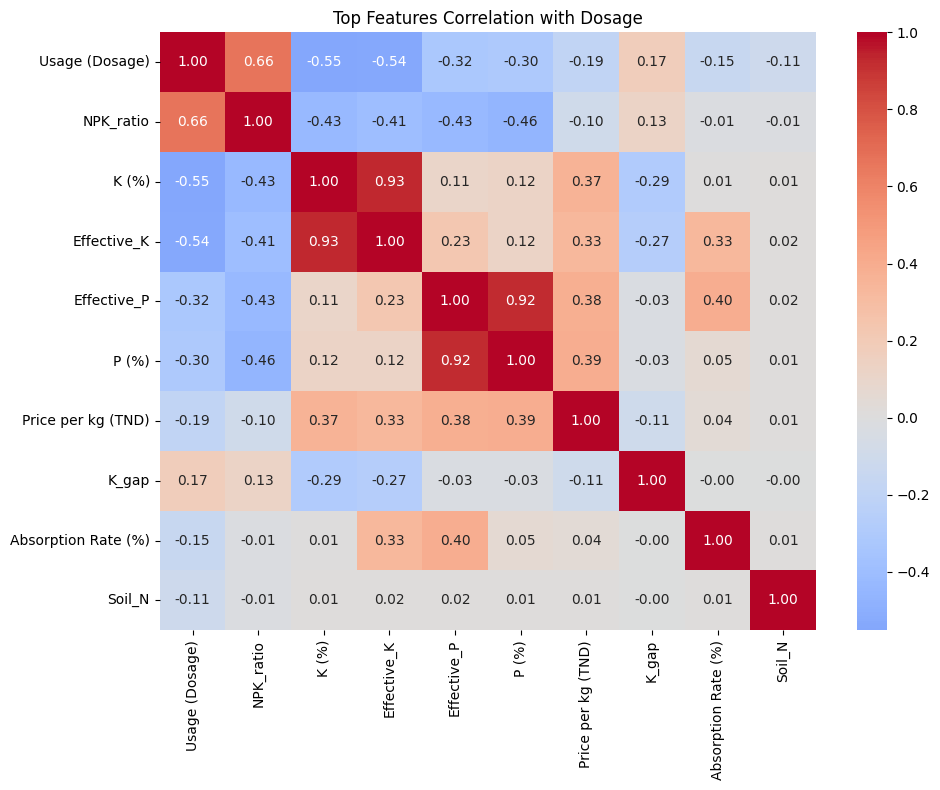

In [56]:
# Select top 10 features most correlated with dosage
top_features = correlation_with_target.abs().sort_values(ascending=False).index[:10]
focused_corr = numerical_features[top_features].corr()

# Create a smaller heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(focused_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Top Features Correlation with Dosage")
plt.tight_layout()
plt.show()

In [57]:
# Get top 10 features correlated with dosage
top_features = correlation_with_target.abs().sort_values(ascending=False).index[:10]
top_correlations = correlation_with_target[top_features]

# Print formatted correlation report
print("="*60)
print("FERTILIZER DOSAGE CORRELATION ANALYSIS REPORT")
print("="*60)

print("\nTOP FEATURES CORRELATED WITH DOSAGE (Usage (Dosage)):")
print("-"*55)
for feature, corr in top_correlations.items():
    strength = ""
    if abs(corr) >= 0.7: strength = "VERY STRONG"
    elif abs(corr) >= 0.5: strength = "STRONG"
    elif abs(corr) >= 0.3: strength = "MODERATE"
    else: strength = "WEAK"

    direction = "increases with" if corr > 0 else "decreases with"
    print(f"{feature:>20}: {corr:.2f} ({strength} {direction} dosage)")

# Get inter-feature correlations
print("\nTOP INTER-FEATURE CORRELATIONS (Potential Multicollinearity):")
print("-"*55)
focused_corr = numerical_features[top_features].corr().abs()

# Get top 5 inter-feature correlations (excluding self-correlation and duplicates)
corr_pairs = (focused_corr.where(np.triu(np.ones(focused_corr.shape), k=1).astype(bool))
              .stack()
              .sort_values(ascending=False)
              .head(5))

for (feature1, feature2), corr in corr_pairs.items():
    print(f"{feature1:>20} ↔ {feature2:<20}: {corr:.2f}")



FERTILIZER DOSAGE CORRELATION ANALYSIS REPORT

TOP FEATURES CORRELATED WITH DOSAGE (Usage (Dosage)):
-------------------------------------------------------
      Usage (Dosage): 1.00 (VERY STRONG increases with dosage)
           NPK_ratio: 0.66 (STRONG increases with dosage)
               K (%): -0.55 (STRONG decreases with dosage)
         Effective_K: -0.54 (STRONG decreases with dosage)
         Effective_P: -0.32 (MODERATE decreases with dosage)
               P (%): -0.30 (MODERATE decreases with dosage)
  Price per kg (TND): -0.19 (WEAK decreases with dosage)
               K_gap: 0.17 (WEAK increases with dosage)
 Absorption Rate (%): -0.15 (WEAK decreases with dosage)
              Soil_N: -0.11 (WEAK decreases with dosage)

TOP INTER-FEATURE CORRELATIONS (Potential Multicollinearity):
-------------------------------------------------------
               K (%) ↔ Effective_K         : 0.93
         Effective_P ↔ P (%)               : 0.92
      Usage (Dosage) ↔ NPK_ratio    

# 📈 Fertilizer Dosage – Correlation Analysis Report

This report summarizes the **relationships between engineered features** and the target variable: **`Usage (Dosage)`**. It also highlights potential **multicollinearity issues** among features that might affect model performance or interpretability.

---

## 🎯 Top Features Correlated with Dosage (`Usage (Dosage)`)

| Feature                | Correlation | Strength      | Interpretation                                 |
|------------------------|-------------|----------------|------------------------------------------------|
| `Usage (Dosage)`       | 1.00        | 🚨 VERY STRONG | Reference point — self-correlation             |
| `NPK_ratio`            | +0.66       | 🔥 STRONG      | N-dominant fertilizers often require higher dosage |
| `K (%)`                | -0.55       | 🔥 STRONG      | Potassium-rich fertilizers tend to be used at lower dosages |
| `Effective_K`          | -0.54       | 🔥 STRONG      | More bioavailable K → less dosage needed       |
| `Effective_P`          | -0.32       | ✅ MODERATE    | Bioavailable phosphorus reduces dosage         |
| `P (%)`                | -0.30       | ✅ MODERATE    | More P in the fertilizer → lower overall usage |
| `Price per kg (TND)`   | -0.19       | 🟡 WEAK        | More expensive fertilizers may be applied more sparingly |
| `K_gap`                | +0.17       | 🟡 WEAK        | Larger K deficiencies may require higher dosage |
| `Absorption Rate (%)`  | -0.15       | 🟡 WEAK        | Higher absorption = more efficient → less fertilizer needed |
| `Soil_N`               | -0.11       | 🟡 WEAK        | Richer soil nitrogen reduces the fertilizer dose |

---

## ⚠️ Top Inter-Feature Correlations (Multicollinearity)

| Feature Pair                     | Correlation | Implication                                          |
|----------------------------------|-------------|------------------------------------------------------|
| `K (%)` ↔ `Effective_K`          | +0.93       | Very high correlation — likely redundant            |
| `P (%)` ↔ `Effective_P`          | +0.92       | Very high correlation — may need dimensionality reduction |
| `Usage (Dosage)` ↔ `NPK_ratio`   | +0.66       | Fertilizer N-dominance strongly influences dosage   |
| `Usage (Dosage)` ↔ `K (%)`       | -0.55       | Potassium content inversely impacts dosage          |
| `Usage (Dosage)` ↔ `Effective_K` | -0.54       | Bioavailable K is a key driver of reduced dosage    |

---

## ✅ Insights Summary

- **Fertilizer composition** (especially NPK balance and nutrient gaps) heavily influences how much dosage is applied.
- **Soil nutrient richness** and **fertilizer efficiency** (via `Absorption Rate` and `Effective_*`) help **reduce the required dosage**.
- **Multicollinearity** among some features (e.g., `P (%)` vs `Effective_P`)

In [58]:
# Drop only one of each high-corr pair to reduce redundancy
'''data = data.drop(columns=['K_Abs_Deficit'], errors='ignore')'''


"data = data.drop(columns=['K_Abs_Deficit'], errors='ignore')"

In [59]:

# Colonnes catégorielles
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nColonnes catégorielles :")
print(categorical_columns)


Colonnes catégorielles :
Index(['Fertilizer Name', 'Fertilizer Type', 'State',
       'Region of Use in Tunisia', 'Specific Crop', 'Application Method'],
      dtype='object')


In [60]:
numerical_columns = data.select_dtypes(include=['number']).columns
# Afficher les résultats
print("Colonnes numériques :")
print(numerical_columns)

Colonnes numériques :
Index(['N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
       'Crop N', 'Crop P', 'Crop K', 'Root Depth (cm)', 'Soil_P', 'Soil_K',
       'Soil_N', 'pH', 'Usage (Dosage)', 'NPK_ratio', 'N_gap', 'P_gap',
       'K_gap', 'Soil_P_suff', 'Soil_K_suff', 'Soil_N_suff', 'Effective_N',
       'Effective_P', 'Effective_K'],
      dtype='object')


In [61]:
from sklearn.preprocessing import LabelEncoder

# ✅ Colonnes à encoder avec LabelEncoder
label_cols = ['Fertilizer Name', 'Fertilizer Type', 'Region of Use in Tunisia', 'State', 'Specific Crop', 'Application Method']
encoders = {}  # Pour stocker les encodeurs si besoin de décoder plus tard

for col in label_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

In [62]:
'''# 2. Détection des colonnes numériques très asymétriques
# -------------------------------
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns.remove('Dosage')  # ⚠️ On exclut la cible

skewed = data[numeric_columns].skew()
to_log = skewed[abs(skewed) > 1.5].index

# -------------------------------
# 3. Application de la log-transformation
# -------------------------------
data[to_log] = data[to_log].apply(lambda x: np.log1p(x))
print("🔁 Colonnes log-transformées :", list(to_log))

# Optionnel : vérifier la skewness après log
print("\n📈 Skewness après log :")
print(data[to_log].skew())'''

'# 2. Détection des colonnes numériques très asymétriques\n# -------------------------------\nnumeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()\nnumeric_columns.remove(\'Dosage\')  # ⚠️ On exclut la cible\n\nskewed = data[numeric_columns].skew()\nto_log = skewed[abs(skewed) > 1.5].index\n\n# -------------------------------\n# 3. Application de la log-transformation\n# -------------------------------\ndata[to_log] = data[to_log].apply(lambda x: np.log1p(x))\nprint("🔁 Colonnes log-transformées :", list(to_log))\n\n# Optionnel : vérifier la skewness après log\nprint("\n📈 Skewness après log :")\nprint(data[to_log].skew())'

In [63]:
# -----------------------------
# 8. CHECK MISSING DATA
# -----------------------------
print("🔍 Missing values:", data.isnull().sum().sum())


🔍 Missing values: 0


In [64]:
# Colonnes numériques
numerical_columns = data.select_dtypes(include=['number']).columns

# Colonnes catégorielles
categorical_columns = data.select_dtypes(include=['object']).columns

# Afficher les résultats
print("Colonnes numériques :")
print(numerical_columns)

print("\nColonnes catégorielles :")
print(categorical_columns)

Colonnes numériques :
Index(['Fertilizer Name', 'N (%)', 'P (%)', 'K (%)', 'Fertilizer Type',
       'Absorption Rate (%)', 'Price per kg (TND)', 'State',
       'Region of Use in Tunisia', 'Specific Crop', 'Crop N', 'Crop P',
       'Crop K', 'Application Method', 'Root Depth (cm)', 'Soil_P', 'Soil_K',
       'Soil_N', 'pH', 'Usage (Dosage)', 'NPK_ratio', 'N_gap', 'P_gap',
       'K_gap', 'Soil_P_suff', 'Soil_K_suff', 'Soil_N_suff', 'Effective_N',
       'Effective_P', 'Effective_K'],
      dtype='object')

Colonnes catégorielles :
Index([], dtype='object')


In [65]:
# -----------------------------
# 9. FINAL TRAIN-TEST SPLIT
# -----------------------------
X = data.drop(columns=['Usage (Dosage)', 'Fertilizer Name'], errors='ignore')

y = data['Usage (Dosage)']

In [66]:
# ============================
# 10. Train-Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Final train-test shape:", X_train.shape, X_test.shape)


✅ Final train-test shape: (8000, 28) (2000, 28)


In [67]:
'''# Normalisation pour Ridge uniquement
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)'''

'# Normalisation pour Ridge uniquement\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)'

# **Modeling + Evaluation**


We will evaluate the following regression models to predict `Usage (Dosage)`:

1. **Tree-Based Models**  
   - `RandomForestRegressor`  
   - `XGBRegressor` (XGBoost)  
   - `GradientBoostingRegressor`  
   - `HistGradientBoostingRegressor` (scikit-learn's optimized implementation)  
   - `CatBoostRegressor` (Handles categorical features natively)  

2. **Linear Model**  
   - `Ridge` (L2-regularized regression to baseline performance)  

3. **Ensemble & Advanced Methods**  
   - `StackingRegressor` (Meta-estimator combining `XGBoost` + `CatBoost` predictions)  
   - `Feedforward Neural Network (FNN)` (Built with `Keras` for non-linear deep learning insights)  

#### **Rationale**:  
- **Tree-based models** to capture non-linear relationships (e.g., strong negative `K (%)` effect).  
- **Ridge regression** as a simple, interpretable baseline.  
- **Stacking/FNN** to test if hybrid/deep learning improves upon standalone models.  

## **Random Forest Regressor**

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)

start = time.time()
rf_search.fit(X_train, y_train)
rf_preds = rf_search.predict(X_test)
end = time.time()

print("📊 Random Forest (Amélioré)")
print(f"Best Parameters: {rf_search.best_params_}")
print("RMSE:", mean_squared_error(y_test, rf_preds) ** 0.5)
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R²:", r2_score(y_test, rf_preds))
print("Training Time (s):", round(end - start, 2))






Fitting 3 folds for each of 5 candidates, totalling 15 fits
📊 Random Forest (Amélioré)
Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
RMSE: 6.719154256547553
MAE: 2.2301863412914718
R²: 0.947221213213954
Training Time (s): 65.63


## **XGBRegressor**

In [69]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Définition de la grille des hyperparamètres à tester
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialisation du modèle XGBRegressor
xgb = XGBRegressor(n_jobs=-1, verbosity=0, random_state=42)

# Paramètres pour RandomizedSearchCV
xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=10,  # Increase iterations for more exploration
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error',
    random_state=42
)


# Enregistrement du temps d'entraînement
start = time.time()

# Entraînement du modèle avec la recherche d'hyperparamètres
xgb_search.fit(X_train, y_train)

# Prédiction sur le jeu de test
xgb_preds = xgb_search.predict(X_test)

# Temps de formation
end = time.time()

# Affichage des résultats
print("📊 XGBoost (Amélioré)")
print(f"Best Parameters: {xgb_search.best_params_}")
print("RMSE:", mean_squared_error(y_test, xgb_preds) ** 0.5)
print("MAE:", mean_absolute_error(y_test, xgb_preds))
print("R²:", r2_score(y_test, xgb_preds))
print("Training Time (s):", round(end - start, 2))

# Affichage des premières prédictions vs réelles pour voir la performance
print("\nComparaison des prédictions et valeurs réelles (top 5):")
comparison = pd.DataFrame({'Réelles': y_test[:5], 'Prédites': xgb_preds[:5]})
print(comparison)







Fitting 3 folds for each of 10 candidates, totalling 30 fits
📊 XGBoost (Amélioré)
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
RMSE: 5.6091864798668185
MAE: 1.9922365106725695
R²: 0.9632184576146177
Training Time (s): 32.08

Comparaison des prédictions et valeurs réelles (top 5):
      Réelles    Prédites
6252    62.43   59.891064
4684     8.13    8.158624
1731     7.52    7.403910
4742   148.29  134.957306
4521    98.90  117.945908


## **Ridge Regression**

In [70]:
# Normalisation pour Ridge uniquement
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Paramètres à tester
param_dist = {
    'alpha': [0.1, 0.5, 1.0, 10.0, 100.0]
}

# RandomizedSearchCV
ridge = Ridge()
ridge_random_search = RandomizedSearchCV(ridge, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Entraînement et prédictions
start = time.time()
ridge_random_search.fit(X_train_scaled, y_train)
ridge_preds = ridge_random_search.predict(X_test_scaled)
end = time.time()

# Résultats
print("📊 Ridge Regression (RandomizedSearchCV)")
print(f"Best Parameters: {ridge_random_search.best_params_}")
print("RMSE:", mean_squared_error(y_test, ridge_preds) ** 0.5)
print("MAE:", mean_absolute_error(y_test, ridge_preds))
print("R²:", r2_score(y_test, ridge_preds))
print("Training Time (s):", round(end - start, 2))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


📊 Ridge Regression (RandomizedSearchCV)
Best Parameters: {'alpha': 1.0}
RMSE: 16.96437018101717
MAE: 9.074840091051012
R²: 0.6635615208798213
Training Time (s): 0.23


## **Gradient Boosting Regressor**

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

gb_pipeline = Pipeline([
    ('preprocessor', 'passthrough'),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

gb_search = RandomizedSearchCV(gb_pipeline, gb_params, n_iter=20, cv=5,
                                scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

start = time.time()
gb_search.fit(X_train, y_train)
end = time.time()

gb_preds = gb_search.predict(X_test)
gb_results = {
    'Model': 'Gradient Boosting',
    'RMSE': mean_squared_error(y_test, rf_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, gb_preds),
    'R²': r2_score(y_test, gb_preds),
    'Training Time (s)': round(end - start, 2),
    'Best Params': gb_search.best_params_
}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [72]:
# Show results
for k, v in gb_results.items():
    print(f"{k}: {v}")


Model: Gradient Boosting
RMSE: 6.719154256547553
MAE: 1.9724639626933889
R²: 0.9629439870681336
Training Time (s): 205.93
Best Params: {'regressor__n_estimators': 200, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1}


## **HistGradientBoosting**

In [73]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_pipeline = Pipeline([
    ('preprocessor', 'passthrough'),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

hgb_params = {
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_iter': [100, 200],
    'regressor__max_depth': [None, 10]
}

hgb_search = RandomizedSearchCV(hgb_pipeline, hgb_params, n_iter=10, cv=5,
                                 scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)

start = time.time()
hgb_search.fit(X_train, y_train)
end = time.time()

hgb_preds = hgb_search.predict(X_test)
hgb_results = {
    'Model': 'HistGradientBoosting',
    'RMSE': mean_squared_error(y_test, rf_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, hgb_preds),
    'R²': r2_score(y_test, hgb_preds),
    'Training Time (s)': round(end - start, 2),
    'Best Params': hgb_search.best_params_
}
# Show results
for k, v in hgb_results.items():
    print(f"{k}: {v}")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Model: HistGradientBoosting
RMSE: 6.719154256547553
MAE: 2.0557020965617725
R²: 0.9621100020139455
Training Time (s): 22.78
Best Params: {'regressor__max_iter': 200, 'regressor__max_depth': None, 'regressor__learning_rate': 0.1}


In [111]:
joblib.dump(hgb_search.best_estimator_, 'hgb_best_model.joblib')


['hgb_best_model.joblib']

In [107]:
joblib.dump(hgb_search.best_estimator_, 'hgb_best_model.joblib')


['hgb_best_model.joblib']

In [109]:
print(hgb_search.best_params_)


{'regressor__max_iter': 200, 'regressor__max_depth': None, 'regressor__learning_rate': 0.1}


In [110]:
loaded_model = joblib.load('hgb_best_model.joblib')
print(loaded_model.get_params())


{'memory': None, 'steps': [('preprocessor', 'passthrough'), ('regressor', HistGradientBoostingRegressor(max_iter=200, random_state=42))], 'transform_input': None, 'verbose': False, 'preprocessor': 'passthrough', 'regressor': HistGradientBoostingRegressor(max_iter=200, random_state=42), 'regressor__categorical_features': 'from_dtype', 'regressor__early_stopping': 'auto', 'regressor__interaction_cst': None, 'regressor__l2_regularization': 0.0, 'regressor__learning_rate': 0.1, 'regressor__loss': 'squared_error', 'regressor__max_bins': 255, 'regressor__max_depth': None, 'regressor__max_features': 1.0, 'regressor__max_iter': 200, 'regressor__max_leaf_nodes': 31, 'regressor__min_samples_leaf': 20, 'regressor__monotonic_cst': None, 'regressor__n_iter_no_change': 10, 'regressor__quantile': None, 'regressor__random_state': 42, 'regressor__scoring': 'loss', 'regressor__tol': 1e-07, 'regressor__validation_fraction': 0.1, 'regressor__verbose': 0, 'regressor__warm_start': False}


In [74]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


## **CatBoostRegressor**

In [75]:
from catboost import CatBoostRegressor

cat_pipeline = Pipeline([
    ('preprocessor', 'passthrough'),
    ('regressor', CatBoostRegressor(verbose=0, random_state=42))
])

cat_params = {
    'regressor__iterations': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__depth': [4, 6, 8]
}

cat_search = RandomizedSearchCV(
    cat_pipeline,
    cat_params,  # ✅ Correct param grid
    n_iter=10,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

start = time.time()
cat_search.fit(X_train, y_train)
end = time.time()

cat_preds = cat_search.predict(X_test)
cat_results = {
    'Model': 'CatBoost',
    'RMSE': mean_squared_error(y_test, cat_preds) ** 0.5,
    'MAE': mean_absolute_error(y_test, cat_preds),
    'R²': r2_score(y_test, cat_preds),
    'Training Time (s)': round(end - start, 2),
    'Best Params': cat_search.best_params_
}

# Show results
for k, v in cat_results.items():
    print(f"{k}: {v}")


Model: CatBoost
RMSE: 5.980009216985057
MAE: 2.1002763099614814
R²: 0.9581944552930654
Training Time (s): 91.9
Best Params: {'regressor__learning_rate': 0.1, 'regressor__iterations': 200, 'regressor__depth': 8}


## **Stacking Regressor (XGBoost + CatBoost)**

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


# Step 1: Extract best parameters from RandomizedSearchCV results
xgb_best_params = xgb_search.best_params_
cat_best_params = {k.replace('regressor__', ''): v for k, v in cat_search.best_params_.items()}

# Step 2: Define the base learners for stacking
estimators = [
    ('xgb', XGBRegressor(**xgb_best_params, random_state=42)),
    ('cat', CatBoostRegressor(**cat_best_params, verbose=0, random_state=42)),  # Corrected params
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))  # New RandomForest model
]

# Step 3: Stacking Regressor with Ridge as final estimator
stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(random_state=42),
    passthrough=True,
    n_jobs=-1
)

# Step 4: Preprocessing (Scaling numerical features)
stacking_preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), X_train.columns)]  # Adjust columns if needed
)

# Step 5: Create the pipeline
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', stacking_preprocessor),
    ('stacking', stacking)
])

# Step 6: Train and evaluate
start_time = time.time()
stacking_pipeline.fit(X_train, y_train)
stacking_train_time = time.time() - start_time

stacking_preds = stacking_pipeline.predict(X_test)
stacking_rmse = mean_squared_error(y_test, stacking_preds) ** 0.5
stacking_mae = mean_absolute_error(y_test, stacking_preds)
stacking_r2 = r2_score(y_test, stacking_preds)

# Step 7: Output results
print(f"Stacking Regressor RMSE: {stacking_rmse:.2f}")
print(f"Stacking Regressor MAE: {stacking_mae:.2f}")
print(f"Stacking Regressor R²: {stacking_r2:.2f}")
print(f"Training Time: {stacking_train_time:.2f} seconds")


Stacking Regressor RMSE: 5.49
Stacking Regressor MAE: 1.99
Stacking Regressor R²: 0.96
Training Time: 94.11 seconds


## **Feedforward Neural Network (FNN) built with Keras**

In [78]:
# Step 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


In [79]:
# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Définir le modèle
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Régression
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Résumé du modèle
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,665 (194.00 KB)

 Trainable params: 49,153 (192.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [80]:
# Early stopping pour éviter le surapprentissage
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 500.7329 - mae: 9.9690 - val_loss: 343.9954 - val_mae: 9.1123
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 152.3331 - mae: 6.1319 - val_loss: 147.4474 - val_mae: 5.3502
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 124.4233 - mae: 5.3855 - val_loss: 138.0804 - val_mae: 4.5127
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 105.3799 - mae: 4.9153 - val_loss: 118.3378 - val_mae: 4.1478
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 84.3531 - mae: 4.5486 - val_loss: 102.3447 - val_mae: 3.8849
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 76.7915 - mae: 4.0908 - val_loss: 81.2579 - val_mae: 3.5797
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 91.1780 - mae: 4.3349 - val_loss: 91.0523 - val_mae: 3.4854
Epoch 8/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 82.2080 - mae: 4.0583 - val_loss: 79.1280 - val_mae: 3.4685
Epoch 9/200
200/200 ━━━

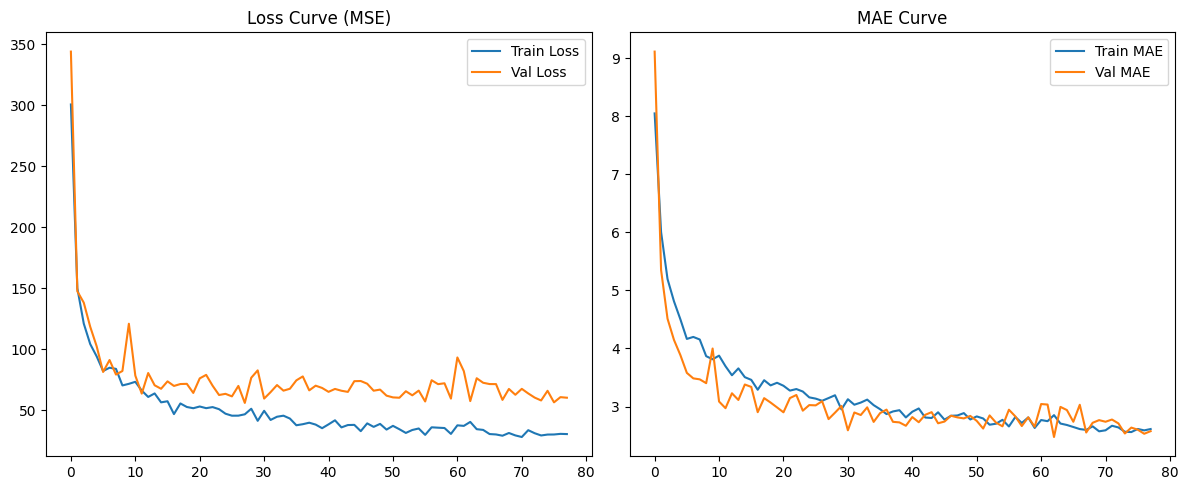

In [81]:
# Afficher les courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve (MSE)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [82]:
# Prédictions et évaluation
y_pred = model.predict(X_test_scaled).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"🔍 Evaluation sur l'ensemble de test :")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
🔍 Evaluation sur l'ensemble de test :
MAE:  3.02
RMSE: 7.44
R²:   0.935


# 📊 Step 4: Compare Model Performance

### 🔹 Métriques utilisées :

- **MAE (Mean Absolute Error)** – *Erreur absolue moyenne*  
  ➤ Moyenne des écarts absolus entre les valeurs réelles et les prédictions.  
  **Unité : kg/ha** (car on prédit une dose d’engrais).  
  ↪ Plus c’est bas, mieux c’est.

- **MSE (Mean Squared Error)** – *Erreur quadratique moyenne*  
  ➤ Moyenne des carrés des écarts. Sensible aux grandes erreurs.  
  **Unité : (kg/ha)²**.  
  ↪ Utilisée pour pénaliser fortement les grosses erreurs.

- **RMSE (Root Mean Squared Error)** – *Racine carrée de MSE*  
  ➤ Représente l’écart-type des erreurs.  
  **Unité : kg/ha**.  
  ↪ Plus interprétable que MSE car dans la même unité que la cible.

- **R² (R-squared / Coefficient de détermination)**  
  ➤ Mesure la proportion de la variance expliquée par le modèle.  
  **Sans unité**, varie entre 0 et 1 (ou négatif si le modèle est très mauvais).  
  ↪ Plus c’est proche de 1, mieux le modèle explique les données.

---

In [83]:
import pandas as pd

# Initialisation
results_df = pd.DataFrame({
    "Model": [],
    "RMSE": [],
    "MAE": [],
    "R²": []
})

# Utilitaire pour stocker
def add_model_results(model_name, y_true, y_pred):
    results_df.loc[len(results_df)] = {
        "Model": model_name,
        "RMSE": mean_squared_error(y_true, y_pred) ** 0.5,
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }


In [84]:
# Ajout des résultats de chaque modèle
add_model_results("Random Forest", y_test, rf_preds)
add_model_results("XGBoost", y_test, xgb_preds)
add_model_results("Ridge", y_test, ridge_preds)
add_model_results("Gradient Boosting", y_test, gb_preds)
add_model_results("HistGradientBoosting", y_test, hgb_preds)
add_model_results("CatBoost", y_test, cat_preds)
add_model_results("Stacking", y_test, stacking_preds)
add_model_results("Neural Net (FNN)", y_test, y_pred)  # y_pred du modèle Keras


In [85]:
print("📊 Résumé des performances de tous les modèles :")
print(results_df.sort_values("RMSE"))  # Trié par RMSE croissante


📊 Résumé des performances de tous les modèles :
                  Model       RMSE       MAE        R²
6              Stacking   5.486924  1.992022  0.964804
1               XGBoost   5.609186  1.992237  0.963218
3     Gradient Boosting   5.630076  1.972464  0.962944
4  HistGradientBoosting   5.693079  2.055702  0.962110
5              CatBoost   5.980009  2.100276  0.958194
0         Random Forest   6.719154  2.230186  0.947221
7      Neural Net (FNN)   7.440945  3.022886  0.935273
2                 Ridge  16.964370  9.074840  0.663562


**prédictions vs valeurs réelles**

In [86]:
import matplotlib.pyplot as plt

def plot_preds(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.4, color='royalblue')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Prédictions")
    plt.title(f"📈 Prédictions vs Réel - {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<ipython-input-86-28d7708b2889>:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


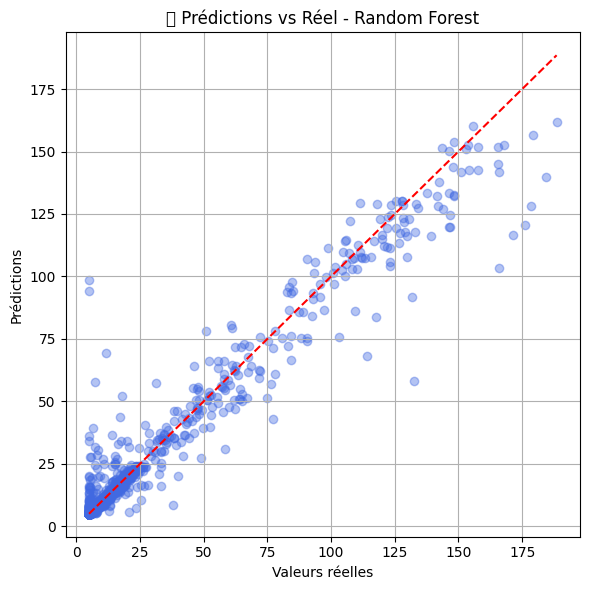

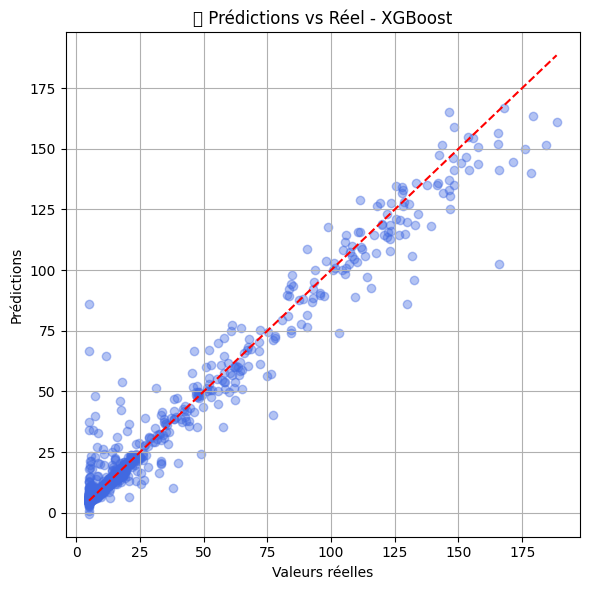

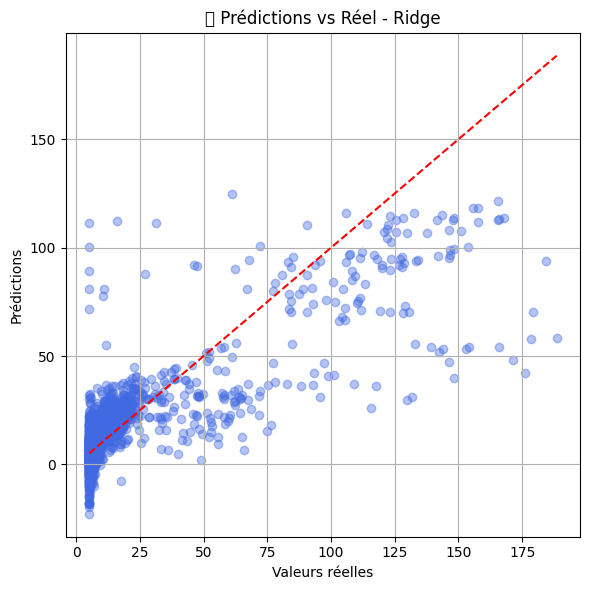

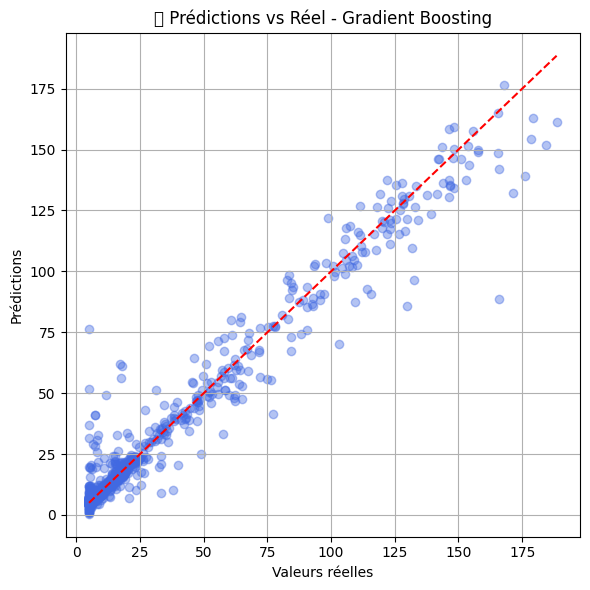

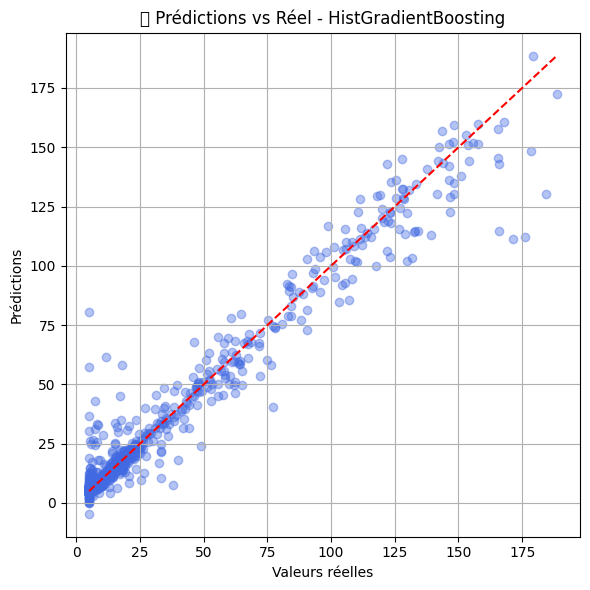

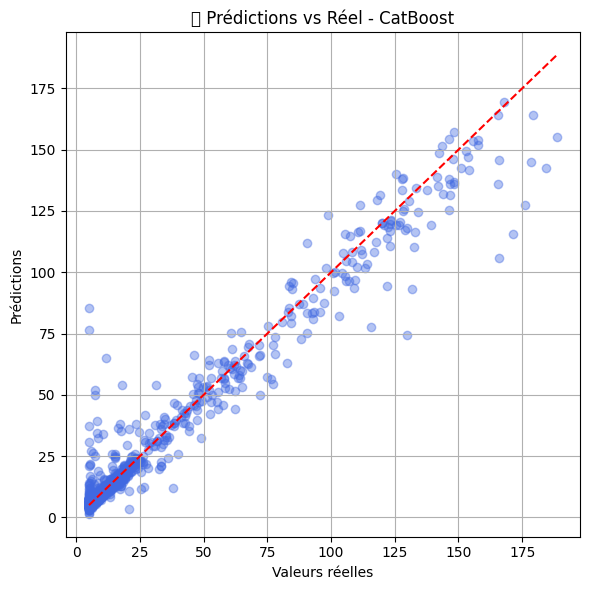

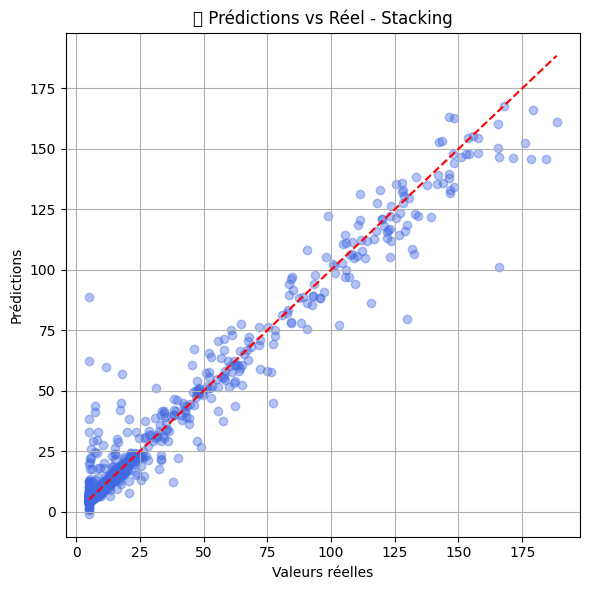

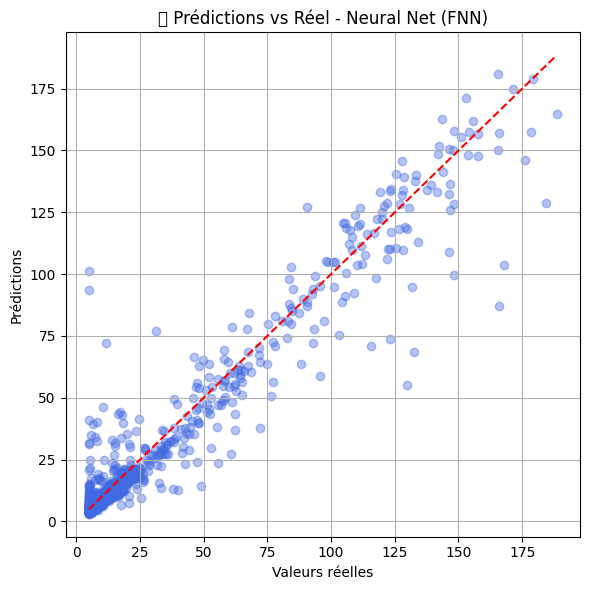

In [87]:
plot_preds(y_test, rf_preds, "Random Forest")
plot_preds(y_test, xgb_preds, "XGBoost")
plot_preds(y_test, ridge_preds, "Ridge")
plot_preds(y_test, gb_preds, "Gradient Boosting")
plot_preds(y_test, hgb_preds, "HistGradientBoosting")
plot_preds(y_test, cat_preds, "CatBoost")
plot_preds(y_test, stacking_preds, "Stacking")
plot_preds(y_test, y_pred, "Neural Net (FNN)")


In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, kde=True, color='darkorange', bins=30)
    plt.title(f'📉 Distribution des résidus - {model_name}')
    plt.xlabel('Erreur (Réel - Prédit)')
    plt.ylabel('Fréquence')
    plt.axvline(0, color='red', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


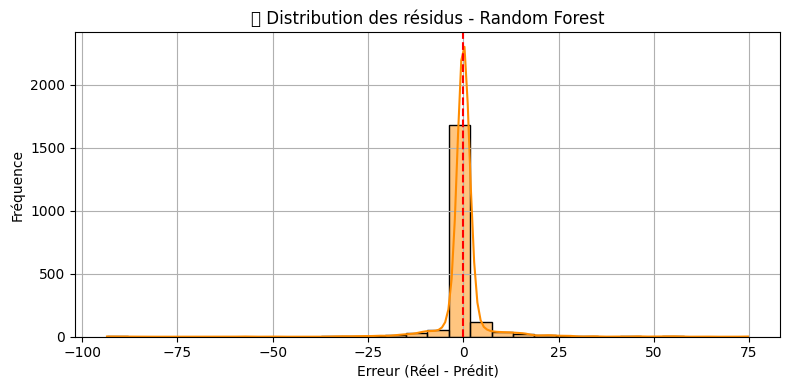

<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


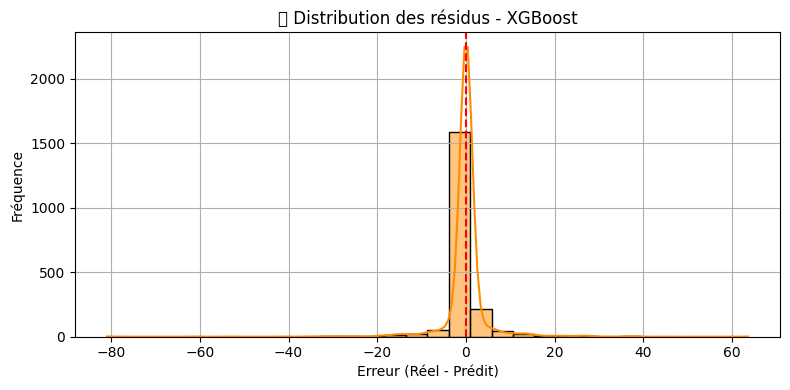

<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


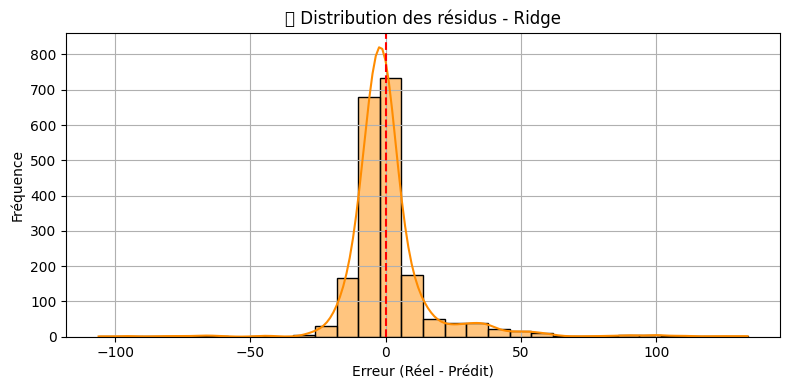

<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


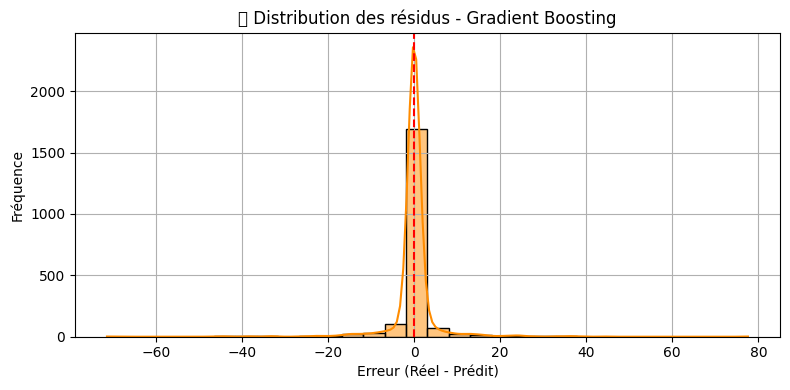

<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


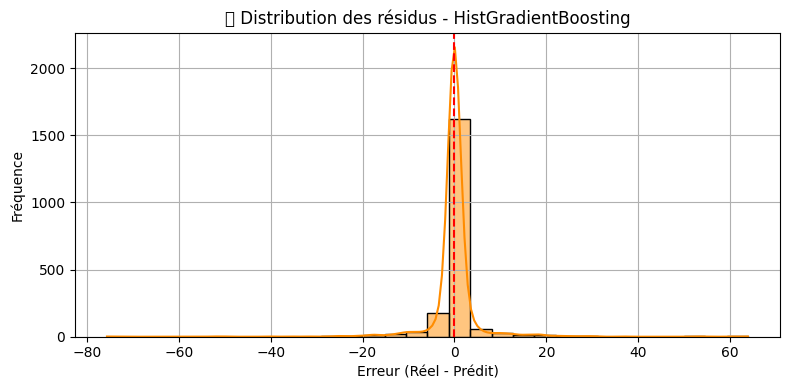

<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


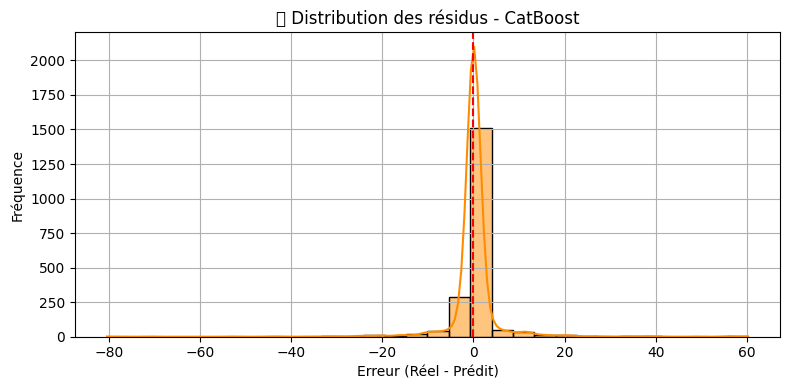

<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


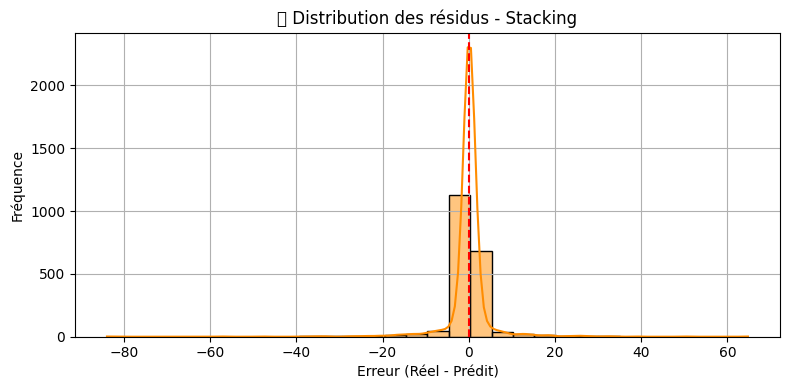

<ipython-input-88-695e815a351b>:13: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


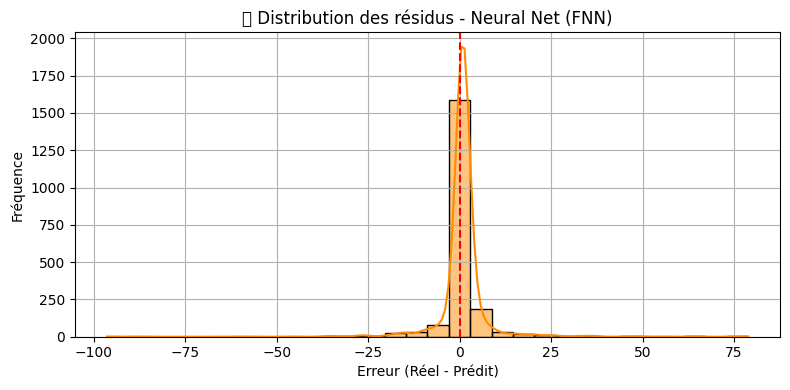

In [89]:
plot_residuals(y_test, rf_preds, "Random Forest")
plot_residuals(y_test, xgb_preds, "XGBoost")
plot_residuals(y_test, ridge_preds, "Ridge")
plot_residuals(y_test, gb_preds, "Gradient Boosting")
plot_residuals(y_test, hgb_preds, "HistGradientBoosting")
plot_residuals(y_test, cat_preds, "CatBoost")
plot_residuals(y_test, stacking_preds, "Stacking")
plot_residuals(y_test, y_pred, "Neural Net (FNN)")


<ipython-input-90-00460902adb7>:18: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


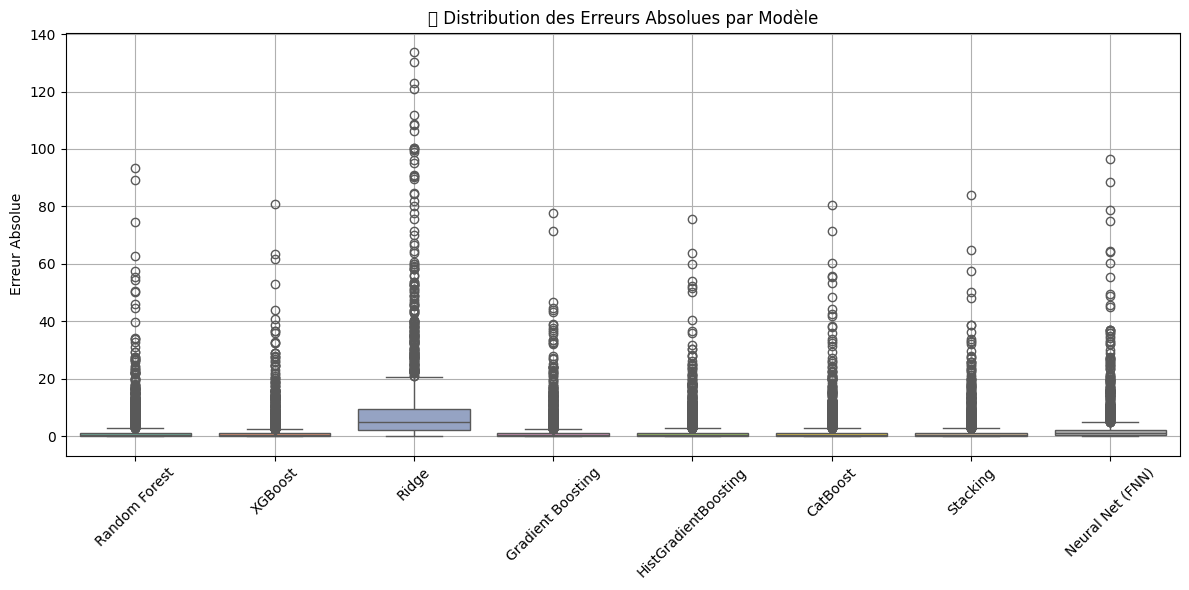

In [90]:
errors_df = pd.DataFrame({
    "Random Forest": abs(y_test - rf_preds),
    "XGBoost": abs(y_test - xgb_preds),
    "Ridge": abs(y_test - ridge_preds),
    "Gradient Boosting": abs(y_test - gb_preds),
    "HistGradientBoosting": abs(y_test - hgb_preds),
    "CatBoost": abs(y_test - cat_preds),
    "Stacking": abs(y_test - stacking_preds),
    "Neural Net (FNN)": abs(y_test - y_pred)
})

plt.figure(figsize=(12, 6))
sns.boxplot(data=errors_df, palette="Set2")
plt.ylabel("Erreur Absolue")
plt.title("📦 Distribution des Erreurs Absolues par Modèle")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
import pandas as pd

# Exemple de données (à remplacer par tes vraies prédictions)
comparison_df = pd.DataFrame({
    'Réel': y_test.values[:10],
    'Random Forest': rf_preds[:10],
    'XGBoost': xgb_preds[:10],
    'Ridge': ridge_preds[:10],
    'Gradient Boosting': gb_preds[:10],
    'HistGradientBoosting': hgb_preds[:10],
    'CatBoost': cat_preds[:10],             # à retirer si non utilisé
    'Stacking': stacking_preds[:10],        # à retirer si non utilisé
    'Neural Network': y_pred[:10]
})

# Arrondir pour lisibilité
comparison_df = comparison_df.round(2)
comparison_df.index = [f"Observation {i+1}" for i in range(len(comparison_df))]

# Affichage
print(comparison_df)


                  Réel  Random Forest     XGBoost   Ridge  Gradient Boosting  \
Observation 1    62.43          71.75   59.889999   29.02              64.00   
Observation 2     8.13           7.56    8.160000    7.00               8.11   
Observation 3     7.52           7.61    7.400000    1.76               7.63   
Observation 4   148.29         132.07  134.960007  113.76             134.11   
Observation 5    98.90         111.34  117.949997   40.73             121.87   
Observation 6    21.12          19.15   19.770000   22.34              20.46   
Observation 7     7.13           6.76    6.910000   12.11               6.76   
Observation 8    13.40          13.28   13.830000   28.38              13.51   
Observation 9     5.76           5.82    5.840000    9.01               5.73   
Observation 10   12.77          13.36   14.000000   15.74              13.61   

                HistGradientBoosting  CatBoost  Stacking  Neural Network  
Observation 1                  68.27     63.

In [94]:
import pandas as pd
import numpy as np

# 1. Données du fertilisant à tester
new_data = pd.DataFrame([{
    'N (%)': 15,
    'P (%)': 15,
    'K (%)': 10,
    'Fertilizer Type': 'Organic',
    'Absorption Rate (%)': 75,
    'Price per kg (TND)': 2.99,
    'State': 'Sidi Bouzid',
    'Region of Use in Tunisia': 'Central',
    'Specific Crop': 'Corn',
    'Crop N': 142,
    'Crop P': 61,
    'Crop K': 34,
    'Application Method': 'Radicular',
    'Root Depth (cm)': 70,
    'Soil_P': 11.6,
    'Soil_K': 77.3,
    'Soil_N': 21.3,
    'pH': 7.286930767432242
}])

# 2. Prétraitement (comme lors de l'entraînement)
numeric_cols = ['N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
                'Soil_N', 'Soil_P', 'Soil_K', 'Crop N', 'Crop P', 'Crop K', 'Root Depth (cm)', 'pH']

for col in numeric_cols:
    q_low, q_high = data[col].quantile([0.05, 0.95])
    new_data[col] = np.clip(new_data[col], q_low, q_high)

to_log = data[numeric_cols].skew()[abs(data[numeric_cols].skew()) > 1.5].index
new_data[to_log] = new_data[to_log].apply(np.log1p)

# 3. Feature engineering
new_data["NPK_ratio"] = new_data["N (%)"] / (new_data["P (%)"] + new_data["K (%)"] + 1e-3)
new_data["N_gap"] = new_data["Crop N"] - new_data["N (%)"]
new_data["P_gap"] = new_data["Crop P"] - new_data["P (%)"]
new_data["K_gap"] = new_data["Crop K"] - new_data["K (%)"]
new_data["Soil_P_suff"] = new_data["Soil_P"] / (new_data["Crop P"] + 1e-3)
new_data["Soil_K_suff"] = new_data["Soil_K"] / (new_data["Crop K"] + 1e-3)
new_data["Soil_N_suff"] = new_data["Soil_N"] / (new_data["Crop N"] + 1e-3)
new_data["Effective_N"] = new_data["N (%)"] * new_data["Absorption Rate (%)"] / 100
new_data["Effective_P"] = new_data["P (%)"] * new_data["Absorption Rate (%)"] / 100
new_data["Effective_K"] = new_data["K (%)"] * new_data["Absorption Rate (%)"] / 100

# 4. Encodage manuel via pd.get_dummies
new_data_encoded = pd.get_dummies(new_data)

# 5. Aligner avec les colonnes de X_train (ajout des colonnes manquantes)
X_new = new_data_encoded.reindex(columns=X_train.columns, fill_value=0)

# 6. Prédiction
best_model = hgb_search.best_estimator_
predicted_dosage = best_model.predict(X_new)[0]

# 7. Résultat
print(f"✅ Prédiction du dosage pour BIOFERT ORGANIC : {predicted_dosage:.2f} kg/ha")


✅ Prédiction du dosage pour BIOFERT ORGANIC : 7.71 kg/ha


In [99]:
import pandas as pd
import numpy as np

# 🔢 1. Données de test
test_data = pd.DataFrame([
    {
        'Fertilizer Name': 'BIOFERT ORGANIC',
        'N (%)': 15,
        'P (%)': 15,
        'K (%)': 10,
        'Fertilizer Type': 'Organic',
        'Absorption Rate (%)': 75,
        'Price per kg (TND)': 2.99,
        'State': 'Sidi Bouzid',
        'Region of Use in Tunisia': 'Central',
        'Specific Crop': 'Corn',
        'Crop N': 142,
        'Crop P': 61,
        'Crop K': 34,
        'Application Method': 'Radicular',
        'Root Depth (cm)': 70,
        'Soil_P': 11.6,
        'Soil_K': 77.3,
        'Soil_N': 21.3,
        'pH': 7.286930767432242
    },
    {
        'Fertilizer Name': 'FLOCROP B',
        'N (%)': 15,
        'P (%)': 10,
        'K (%)': 5,
        'Fertilizer Type': 'Liquid',
        'Absorption Rate (%)': 70,
        'Price per kg (TND)': 2.34,
        'State': 'Bizerte',
        'Region of Use in Tunisia': 'North',
        'Specific Crop': 'Olive',
        'Crop N': 146,
        'Crop P': 70,
        'Crop K': 40,
        'Application Method': 'Radicular and Foliar',
        'Root Depth (cm)': 80,
        'Soil_P': 28.446520598418044,
        'Soil_K': 83.06576670595635,
        'Soil_N': 46.38557874754839,
        'pH': 7.114030877983656
    },
     {    'Fertilizer Name': 'MICROFERT 12-0-0 + 1Zn',
    'N (%)': 12,
    'P (%)': 0,
    'K (%)': 0,
    'Fertilizer Type': 'Chemical',
    'Absorption Rate (%)': 50,
    'Price per kg (TND)': 1.34,
    'State': 'Ariana',
    'Region of Use in Tunisia': 'North',
    'Specific Crop': 'Barley',
    'Crop N': 127,
    'Crop P': 39,
    'Crop K': 57,
    'Application Method': 'Foliar',
    'Root Depth (cm)': 55,
    'Soil_P': 19.4471260944282,
    'Soil_K': 95.55683262198642,
    'Soil_N': 32.3,
    'pH': 7.339914885876848
         #161
     },
     {
         'Fertilizer Name': 'UREA 46-0-0',
    'N (%)': 46,
    'P (%)': 0,
    'K (%)': 0,
    'Fertilizer Type': 'Organic',
    'Absorption Rate (%)': 75,
    'Price per kg (TND)': 3.46,
    'State': 'Manouba',
    'Region of Use in Tunisia': 'North',
    'Specific Crop': 'Olive',
    'Crop N': 146,
    'Crop P': 70,
    'Crop K': 40,
    'Application Method': 'Soil Application',
    'Root Depth (cm)': 80,
    'Soil_P': 38.97331264970756,
    'Soil_K': 95.5238196876326,
    'Soil_N': 34.74499257981502,
    'pH': 6.846633971156126
      #84.11

     }

])

# 🔁 2. Prétraitement numérique
numeric_cols = ['N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
                'Soil_N', 'Soil_P', 'Soil_K', 'Crop N', 'Crop P', 'Crop K', 'Root Depth (cm)', 'pH']

for col in numeric_cols:
    q_low, q_high = data[col].quantile([0.05, 0.95])
    test_data[col] = np.clip(test_data[col], q_low, q_high)

# Log transform
to_log = data[numeric_cols].skew()[abs(data[numeric_cols].skew()) > 1.5].index
test_data[to_log] = test_data[to_log].apply(np.log1p)

# ⚙️ 3. Feature engineering
test_data["NPK_ratio"] = test_data["N (%)"] / (test_data["P (%)"] + test_data["K (%)"] + 1e-3)
test_data["N_gap"] = test_data["Crop N"] - test_data["N (%)"]
test_data["P_gap"] = test_data["Crop P"] - test_data["P (%)"]
test_data["K_gap"] = test_data["Crop K"] - test_data["K (%)"]
test_data["Soil_P_suff"] = test_data["Soil_P"] / (test_data["Crop P"] + 1e-3)
test_data["Soil_K_suff"] = test_data["Soil_K"] / (test_data["Crop K"] + 1e-3)
test_data["Soil_N_suff"] = test_data["Soil_N"] / (test_data["Crop N"] + 1e-3)
test_data["Effective_N"] = test_data["N (%)"] * test_data["Absorption Rate (%)"] / 100
test_data["Effective_P"] = test_data["P (%)"] * test_data["Absorption Rate (%)"] / 100
test_data["Effective_K"] = test_data["K (%)"] * test_data["Absorption Rate (%)"] / 100

# 🔤 4. Encodage manuel
test_data_encoded = pd.get_dummies(test_data)

# 🧩 5. Alignement avec X_train
X_test = test_data_encoded.reindex(columns=X_train.columns, fill_value=0)

# 📈 6. Prédiction
best_model = hgb_search.best_estimator_
predictions = best_model.predict(X_test)

# 📢 7. Affichage des résultats
for name, pred in zip(test_data["Fertilizer Name"], predictions):
    print(f"✅ {name} → Dosage prédit : {pred:.2f} kg/ha")


✅ BIOFERT ORGANIC → Dosage prédit : 7.71 kg/ha
✅ FLOCROP B → Dosage prédit : 13.25 kg/ha
✅ MICROFERT 12-0-0 + 1Zn → Dosage prédit : 159.01 kg/ha
✅ UREA 46-0-0 → Dosage prédit : 93.79 kg/ha


In [115]:
import pandas as pd
import numpy as np
import joblib

# 🔢 1. Données de test (4 échantillons)
test_data = pd.DataFrame([
    {
        'Fertilizer Name': 'BIOFERT ORGANIC',
        'N (%)': 15,
        'P (%)': 15,
        'K (%)': 10,
        'Fertilizer Type': 'Organic',
        'Absorption Rate (%)': 75,
        'Price per kg (TND)': 2.99,
        'State': 'Sidi Bouzid',
        'Region of Use in Tunisia': 'Central',
        'Specific Crop': 'Corn',
        'Crop N': 142,
        'Crop P': 61,
        'Crop K': 34,
        'Application Method': 'Radicular',
        'Root Depth (cm)': 70,
        'Soil_P': 11.6,
        'Soil_K': 77.3,
        'Soil_N': 21.3,
        'pH': 7.286930767432242
    },
    {
        'Fertilizer Name': 'FLOCROP B',
        'N (%)': 15,
        'P (%)': 10,
        'K (%)': 5,
        'Fertilizer Type': 'Liquid',
        'Absorption Rate (%)': 70,
        'Price per kg (TND)': 2.34,
        'State': 'Bizerte',
        'Region of Use in Tunisia': 'North',
        'Specific Crop': 'Olive',
        'Crop N': 146,
        'Crop P': 70,
        'Crop K': 40,
        'Application Method': 'Radicular and Foliar',
        'Root Depth (cm)': 80,
        'Soil_P': 28.446520598418044,
        'Soil_K': 83.06576670595635,
        'Soil_N': 46.38557874754839,
        'pH': 7.114030877983656
    },
    {
        'Fertilizer Name': 'MICROFERT 12-0-0 + 1Zn',
        'N (%)': 12,
        'P (%)': 0,
        'K (%)': 0,
        'Fertilizer Type': 'Chemical',
        'Absorption Rate (%)': 50,
        'Price per kg (TND)': 1.34,
        'State': 'Ariana',
        'Region of Use in Tunisia': 'North',
        'Specific Crop': 'Barley',
        'Crop N': 127,
        'Crop P': 39,
        'Crop K': 57,
        'Application Method': 'Foliar',
        'Root Depth (cm)': 55,
        'Soil_P': 19.4471260944282,
        'Soil_K': 95.55683262198642,
        'Soil_N': 32.3,
        'pH': 7.339914885876848
    },
    {
        'Fertilizer Name': 'UREA 46-0-0',
        'N (%)': 46,
        'P (%)': 0,
        'K (%)': 0,
        'Fertilizer Type': 'Organic',
        'Absorption Rate (%)': 75,
        'Price per kg (TND)': 3,
        'State': 'Manouba',
        'Region of Use in Tunisia': 'North',
        'Specific Crop': 'Olive',
        'Crop N': 146,
        'Crop P': 70,
        'Crop K': 40,
        'Application Method': 'Soil Application',
        'Root Depth (cm)': 80,
        'Soil_P': 30,
        'Soil_K': 90,
        'Soil_N': 34,
        'pH': 6
    }
])

# 🔁 2. Prétraitement des variables numériques
numeric_cols = ['N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
                'Soil_N', 'Soil_P', 'Soil_K', 'Crop N', 'Crop P', 'Crop K', 'Root Depth (cm)', 'pH']

for col in numeric_cols:
    q_low, q_high = data[col].quantile([0.05, 0.95])
    test_data[col] = np.clip(test_data[col], q_low, q_high)

# Log transform
to_log = data[numeric_cols].skew()[abs(data[numeric_cols].skew()) > 1.5].index
test_data[to_log] = test_data[to_log].apply(np.log1p)

# ⚙️ 3. Feature Engineering
test_data["NPK_ratio"] = test_data["N (%)"] / (test_data["P (%)"] + test_data["K (%)"] + 1e-3)
test_data["N_gap"] = test_data["Crop N"] - test_data["N (%)"]
test_data["P_gap"] = test_data["Crop P"] - test_data["P (%)"]
test_data["K_gap"] = test_data["Crop K"] - test_data["K (%)"]
test_data["Soil_P_suff"] = test_data["Soil_P"] / (test_data["Crop P"] + 1e-3)
test_data["Soil_K_suff"] = test_data["Soil_K"] / (test_data["Crop K"] + 1e-3)
test_data["Soil_N_suff"] = test_data["Soil_N"] / (test_data["Crop N"] + 1e-3)
test_data["Effective_N"] = test_data["N (%)"] * test_data["Absorption Rate (%)"] / 100
test_data["Effective_P"] = test_data["P (%)"] * test_data["Absorption Rate (%)"] / 100
test_data["Effective_K"] = test_data["K (%)"] * test_data["Absorption Rate (%)"] / 100

# 🔤 4. Encodage one-hot des variables catégorielles
test_data_encoded = pd.get_dummies(test_data)

# 🧩 5. Alignement des colonnes avec l'entraînement
# X_train doit avoir été chargé auparavant
X_test = test_data_encoded.reindex(columns=X_train.columns, fill_value=0)

# 📈 6. Chargement du meilleur modèle sauvegardé
best_model = joblib.load('hgb_best_model.joblib')

# 🔮 7. Prédictions
predictions = best_model.predict(X_test)

# 📢 8. Résultats
print("🎯 Dosages prévus (en kg/ha) :")
for name, pred in zip(test_data["Fertilizer Name"], predictions):
    print(f"✅ {name} → {pred:.2f} kg/ha")


🎯 Dosages prévus (en kg/ha) :
✅ BIOFERT ORGANIC → 7.71 kg/ha
✅ FLOCROP B → 13.25 kg/ha
✅ MICROFERT 12-0-0 + 1Zn → 159.01 kg/ha
✅ UREA 46-0-0 → 90.22 kg/ha


**✅ 1. Model Comparison Table**

In [ ]:
# 📋 1. Affichage du tableau
print("📊 Résumé des performances :")
print(df_summary)

**📊 2. Bar Chart of Metrics (MAE, RMSE, R²)**

In [ ]:
plt.figure(figsize=(17, 8))
metrics = ['RMSE', 'MAE', 'R²']
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.barplot(x='Model', y=metric, data=df_summary, palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'{metric} by Model')
    plt.tight_layout()

plt.suptitle('Comparaison des Modèles (Bar Charts)', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

**📈 3. Actual vs Predicted Plot (All Models)**

In [ ]:
plt.figure(figsize=(15, 10))
for i, (name, preds) in enumerate(model_results.items(), 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=y_test, y=preds, alpha=0.4, edgecolor=None)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(name)

plt.suptitle('Actual vs Predicted for Each Model', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sélection des 10 premiers échantillons
y_true_10 = y_test[:200].values
y_pred_10 = xgb_preds[:200]  # prédictions déjà remises au carré (inversées)

# Courbe de comparaison
plt.figure(figsize=(10, 6))
plt.plot(y_true_10, label='Dosage Réel (kg/ha)', marker='o')
plt.plot(y_pred_10, label='Dosage Prédit (kg/ha)', marker='x')
plt.title("Comparaison des Dosages Réels vs Prédits (XGBoost)")
plt.xlabel("Échantillons (exemples)")
plt.ylabel("Usage (Dosage) en kg/ha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Optionnel : afficher aussi les valeurs sous forme de tableau
import pandas as pd

df_compare = pd.DataFrame({
    "Échantillon": list(range(1, 201)),
    "Dosage Réel (kg/ha)": y_true_10,
    "Dosage Prédit (kg/ha)": y_pred_10,
    "Différence absolue": np.abs(y_true_10 - y_pred_10),
    "Erreur relative (%)": np.abs((y_true_10 - y_pred_10) / y_true_10 * 100).round(2)
})

print("\n📋 Comparaison des 10 premiers échantillons :")
print(df_compare.to_string(index=False))


**Analyser les Résidus (Erreurs du modèle)**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choisis le modèle ici (remplace xgb_preds si tu utilises rf_preds, gb_preds, etc.)
residuals = y_test - xgb_preds

sns.histplot(residuals, kde=True)
plt.title("Distribution des résidus (XGBoost)")
plt.xlabel("Erreur de prédiction")
plt.ylabel("Densité")
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Calcul des résidus
residuals = y_test - xgb_preds

# Statistiques descriptives
residuals_stats = pd.Series(residuals).describe()
print("📊 Statistiques des résidus (XGBoost) :")
print(residuals_stats)

# Moyenne absolue des résidus
mae = np.mean(np.abs(residuals))
print(f"MAE (Mean Absolute Error) : {mae:.4f}")

# Écart-type des résidus
std_residuals = np.std(residuals)
print(f"Écart-type des résidus : {std_residuals:.4f}")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Prédictions du modèle Stacked
stacked_preds = stacked_model.predict(X_test)

# Sélection des 200 premiers échantillons
y_true_200 = y_test[:300].values
y_pred_200 = stacked_preds[:300]

# 📈 Courbe de comparaison
plt.figure(figsize=(16, 8))
plt.plot(y_true_200, label='Dosage Réel (kg/ha)', marker='o')
plt.plot(y_pred_200, label='Dosage Prédit (Stacked)', marker='x')
plt.title("Comparaison des Dosages Réels vs Prédits (Stacked Model)")
plt.xlabel("Échantillons (exemples)")
plt.ylabel("Usage (Dosage) en kg/ha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📋 Tableau comparatif
df_compare_stacked = pd.DataFrame({
    "Échantillon": list(range(1, 301)),
    "Dosage Réel (kg/ha)": y_true_200,
    "Dosage Prédit (kg/ha)": y_pred_200,
    "Différence absolue": np.abs(y_true_200 - y_pred_200),
    "Erreur relative (%)": np.abs((y_true_200 - y_pred_200) / y_true_200 * 100).round(2)
})

print("\n📋 Comparaison des 200 premiers échantillons (Stacked Model) :")
print(df_compare_stacked.to_string(index=False))
